# Design Thinking Data Science Project

# Overview

This project focuses on developing predictive models for paddy yield productivity in Indonesia, leveraging early-year weather data and geographical insights to address the diverse agricultural challenges of the region. Indonesia, as one of the largest rice-producing nations, relies heavily on paddy cultivation for food security and economic stability. By tailoring predictive models to specific provinces, this project aims to provide actionable insights to improve agricultural practices and policy decisions.

### Problem Statement
Indonesia relies on rice imports to manage shortages caused by harvest failures due to climate instability (e.g., droughts, floods). However, the rice import approval process is complex and time-consuming, leading to delays in getting rice to the market. This bureaucratic inefficiency exacerbates food insecurity, leaving vulnerable populations at risk during periods of underproduction. Additionally, stockpiling rice, often used as a temporary solution, imposes a fiscal burden, distorts market dynamics, and is unsustainable in the long term. As a result, the current system struggles to effectively ensure food security through importation.

**How might we assist the government to leverage early-year weather data to predict annual crop yield, enabling proactive strategies thus addressing potential food shortages or surpluses in Indonesia?**

# Import Libaries

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import re
import seaborn as sns
import missingno as msno
from typing import TypeAlias
from typing import Optional, Any    

Number: TypeAlias = int | float
plt.rcParams.update({'font.size': 7})


# Dataset Loading

### Dataset: Indonesia daily climate data from 2010 to 2022 
Link: https://www.kaggle.com/datasets/greegtitan/indonesia-climate/data
This dataset belongs to Badan Meteorologi, Klimatologi, dan Geofisika (BMKG) Indonesia (Meteorology, Climatology, and Geophysical Agency in English) that's available in dataonline.bmkg.go.id/data_gempa_bumi

The dataset contains daily climate data from various weather stations across Indonesia from 2010 to 2022. The data includes measurements of temperature, humidity, rainfall, sunshine duration, and wind conditions. Each row represents a daily record from a specific weather station.


Feature | Description | Hypothesis
--- | --- | ---
Tn | Minimum temperature (°C) | Minimum temperature does not capture temperature variability which is an important factor for crop health. We will need to transform this data with Tx to get range of temperature.
Tx | Maximum temperature (°C) | Maximum temperature does not capture temperature variability which is an important factor for crop health. We will need to transform this data. We will need to transform this data with Tn to get range of temperature.
Tavg | Average temperature (°C) | Average temperature reflects the overall thermal environment for the crop, influencing growth rates and development cycles.
RH_avg | Average humidity (%) | Humidity influences water availability and evapotranspiration rates, which are essential for plant hydration and nutrient uptake.
RR | Rainfall (mm) | Rainfall provides water for crop growth. Insufficient or excessive rainfall can negatively affect crop yields.
ss | Duration of sunshine (fraction of 24 hours) | Sunshine duration determines the amount of light available for photosynthesis, which directly impacts growth and productivity.
ff_x | Maximum wind speed (m/s) | High wind speeds can damage crops physically, affecting their yield. Wind can also impact pollination and seed dispersal for certain crops.
ddd_x | Wind direction at maximum speed (°) | Wind direction which is a categorical data. Hence we won't use this as a feature..
ff_avg | Average wind speed (m/s) | Average wind speed influences evaporation and cooling, which can impact soil moisture retention and overall plant health.
ddd_car | Most frequent wind direction (direction initial) | The predominant wind direction which is a categorical data. Hence we won't use this as a feature.
station_id | Station ID which recorded the data | Station ID can help match climatic data with crop production data by province.

In [228]:

weatherdf: pd.DataFrame = pd.read_csv("/voc/work/weather/climate_data.csv")

# # provide province name based on province_id
provincedf: pd.DataFrame = pd.read_csv("/voc/work/weather/province_detail.csv")

# # provide province_id based on station_id feature in weatherdf
stationdf: pd.DataFrame = pd.read_csv("/voc/work/weather/station_detail.csv") 

#weatherdf: pd.DataFrame = pd.read_csv("D:/term3_dtp/weather/climate_data.csv")

# provide province name based on province_id
#provincedf: pd.DataFrame = pd.read_csv("D:/term3_dtp/weather/province_detail.csv")

# provide province_id based on station_id feature in weatherdf
#stationdf: pd.DataFrame = pd.read_csv("D:/term3_dtp/weather/station_detail.csv") 

display(weatherdf)

,date,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ddd_x,ff_avg,ddd_car,station_id
0,01-01-2010,21.4,30.2,27.1,82.0,9.0,0.5,7.0,90.0,5.0,E,96001
1,02-01-2010,21.0,29.6,25.7,95.0,24.0,0.2,6.0,90.0,4.0,E,96001
2,03-01-2010,20.2,26.8,24.5,98.0,63.0,0.0,5.0,90.0,4.0,E,96001
3,04-01-2010,21.0,29.2,25.8,90.0,0.0,0.1,4.0,225.0,3.0,SW,96001
4,05-01-2010,21.2,30.0,26.7,90.0,2.0,0.4,NaN,NaN,NaN,NaN,96001
...,...,...,...,...,...,...,...,...,...,...,...,...
589260,27-12-2020,25.2,31.2,29.2,74.0,0.0,1.4,4.0,280.0,2.0,C,97980
589261,28-12-2020,25.3,31.6,28.1,78.0,NaN,3.0,12.0,260.0,2.0,C,97980
589262,29-12-2020,24.6,32.3,28.4,81.0,NaN,6.5,5.0,260.0,2.0,SW,97980
589263,30-12-2020,25.2,32.6,28.4,80.0,0.0,2.4,7.0,260.0,2.0,C,97980


### Dataset: Crop productivity yearly 2008-2015 (multiple datasets)

link to dataset: https://www.bps.go.id/en/statistics-table/2/MjIjMg==/productivity--quintal-hectare-.html.
Data belongs to Badan Pusat Statistik, the Central Bureau of Statistics.

These datasets contains agricultural productivity data from various provinces from 2008 to 2015 (splitted into multiple files on the database). It includes productivity metrics for different crops such as paddy, maize, soybean, peanut, mungbean, cassava, and sweet potato. Each column represents either a province, a crop, or productivity figures across the years.

| Column       | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| Productivity | This column represents the productivity of various crops measured in **quintal per hectare**. |
| Provinces    | This column lists the 38 provinces in Indonesia where the productivity data was collected. |
| Crops        | This column includes paddy, maize, soybean, peanut, mungbean, cassava, and sweet potato. |
| Years        | This column represents the years from 2008 to 2015 for which the productivity data is available. |

In [229]:
data_2008_2010 = pd.read_csv("/voc/work/crop_productivity/Productivity, 2008-2010.csv")
data_2011_2013 = pd.read_csv("/voc/work/crop_productivity/Productivity, 2011-2013.csv")
data_2014_2015 = pd.read_csv("/voc/work/crop_productivity/Productivity, 2014-2015.csv")
# data_2008_2010 = pd.read_csv("crop_productivity\Productivity, 2008-2010.csv")
# data_2011_2013 = pd.read_csv("crop_productivity/Productivity, 2011-2013.csv")
# data_2014_2015 = pd.read_csv("crop_productivity/Productivity, 2014-2015.csv")
display(data_2011_2013.head())
display(data_2014_2015.head())
display(data_2008_2010.head())

,38 Province,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,NaN,Productivity (Quintal/Hectare),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Paddy,NaN,NaN,Maize,NaN,NaN,Soybean,NaN,NaN,...,NaN,Mungbean,NaN,NaN,Cassava,NaN,NaN,Sweet Potato,NaN,NaN
2,NaN,2011,2012,2013.00,2011,2012,2013,2011,2012,2013,...,2013,2011,2012,2013,2011,2012,2013,2011,2012,2013
3,ACEH,46.57,46.12,46.68,40.35,38.3,40.33,14.14,14.45,14.72,...,12.38,10.37,10.6,10.58,127.66,128.64,127.48,104.17,105.66,106.05
4,SUMATERA UTARA,47.62,48.56,50.17,50.71,55.41,55.87,10.01,9.9,10.33,...,12.11,10.82,10.91,11,287.83,302.34,322.06,123.56,127.84,128.2


,38 Province,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,NaN,Productivity (Quintal/Hectare),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Paddy,NaN,Maize,NaN,Soybean,NaN,Peanut,NaN,Mungbean,NaN,Cassava,NaN,Sweet Potato,NaN
2,NaN,2014,2015.00,2014,2015.00,2014,2015.00,2014,2015.00,2014,2015.00,2014,2015.00,2014,2015.00
3,ACEH,48.39,50.56,42.72,42.76,14.81,14.61,12.31,12.52,10.71,10.51,130.02,130.87,107.38,112.67
4,SUMATERA UTARA,50.62,51.74,57.82,62.33,11.36,12.35,11.76,11.60,11.17,11.28,328.88,338.54,131.74,136.69


,38 Province,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,NaN,Productivity (Quintal/Hectare),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Paddy,NaN,NaN,Maize,NaN,NaN,Soybean,NaN,NaN,...,NaN,Mungbean,NaN,NaN,Cassava,NaN,NaN,Sweet Potato,NaN,NaN
2,NaN,2008,2009,2010,2008,2009,2010,2008,2009,2010,...,2010,2008,2009,2010,2008,2009,2010,2008,2009,2010
3,ACEH,42.61,43.32,44.92,33.04,34.67,38.07,13.34,14.09,14.24,...,12.66,10.43,10.49,10.61,124.16,127.47,142.06,99.41,100.71,100.77
4,SUMATERA UTARA,44.63,45.91,47.47,45.71,47.08,50.13,12.14,12.36,12.1,...,11.33,10.65,10.73,10.76,194.19,260.88,279.48,110.69,113.39,120.61


### Dataset: Crop productivity yearly 2014-2017 

link to dataset: https://bdsp2.pertanian.go.id/bdsp/id/lokasi.
Data belongs to the Ministry of Agriculture of the Republic of Indonesia.

This dataset contains multiple sheets, each corresponding to the yearly production data for a specific crop from 2014 to 2017 (with one exception extending to 2020). It includes productivity metrics for different crops such as paddy, maize, soybean, peanut, mungbean, cassava, and sweet potato. Each column represents either a province, a crop, or productivity figures across the years.

| Column       | Description                                                                 |
|--------------|-----------------------------------------------------------------------------|
| Lokasi       | This column lists the 34 provinces in Indonesia where the productivity data was collected. |
| 2014,...2017 | This column represents the productivity measured in **quintal per hectare** for each year |

Different crops are in different sheets.

In [230]:
excel_file = pd.ExcelFile("/voc/work/crop_productivity/Indonesian Food Crop Production 2014-2017 (Yearly).xlsx")
#excel_file = pd.ExcelFile("D:/term3_dtp/crop_productivity/Indonesian Food Crop Production 2014-2017 (Yearly).xlsx")

maize_data = excel_file.parse('Maize 2014-2017')
soybean_data = excel_file.parse('Soybean 2014-2017')
peanut_data = excel_file.parse('Peanut 2014-2017')
mungbean_data = excel_file.parse('Mung Bean 2014-2017')
sweet_potato_data = excel_file.parse('Sweet Potato 2014-2017')
cassava_data = excel_file.parse('Cassava 2014-2017')
rice_paddy_data = excel_file.parse('Rice Paddy 2014-2020')

display(maize_data.head())

,No,Lokasi,2014,2015,2016,2017
0,1,11 - Aceh,"42,72","42,76","45,22","47,51"
1,2,12 - Sumatera Utara,"57,82","62,33","61,63","61,87"
2,3,13 - Sumatera Barat,"65,02","68,61","70,02","69,26"
3,4,14 - Riau,"23,76","24,85","24,88","25,15"
4,5,15 - Jambi,"54,95","60,94","60,77","63,63"


## Data Pre-processing

The **crop productivity 2008 - 2015** datasets have inconsistencies, such as misaligned headers and unnecessary rows. Let’s clean them and merge them into a unified dataset with continuous years for usability.

| Province       | Productivity       | Crop           | Year |
|----------------|--------------------|----------------|------|


In [231]:
def clean_and_unpivot(dataset, start_year, end_year):
    # Skip metadata rows
    cleaned = dataset.iloc[2:].reset_index(drop=True)

    # Set headers based on the first row, then drop that row
    cleaned.columns = ["Province", *[f"{crop}_{year}" for crop in [
        "Paddy", "Maize", "Soybean", "Peanut", "Mungbean", "Cassava", "SweetPotato"]
        for year in range(start_year, end_year + 1)]]
    cleaned = cleaned.drop(0).reset_index(drop=True)

    # Convert all numeric columns to floats where applicable
    numeric_columns = cleaned.columns[1:]
    cleaned[numeric_columns] = cleaned[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Unpivot data: Province, Year, and Crop as separate columns
    melted = cleaned.melt(id_vars=["Province"], var_name="Crop_Year", value_name="Productivity")
    melted[["Crop", "Year"]] = melted["Crop_Year"].str.split("_", expand=True)
    melted = melted.drop(columns=["Crop_Year"])

    return melted

cleaned_datasets = {
    "2008-2010": clean_and_unpivot(data_2008_2010, 2008, 2010),
    "2011-2013": clean_and_unpivot(data_2011_2013, 2011, 2013),
    "2014-2015": clean_and_unpivot(data_2014_2015, 2014, 2015),
}

crop_prod_2008_2015_df = pd.concat(cleaned_datasets.values(), ignore_index=True)

display(crop_prod_2008_2015_df)

,Province,Productivity,Crop,Year
0,ACEH,42.61,Paddy,2008
1,SUMATERA UTARA,44.63,Paddy,2008
2,SUMATERA BARAT,46.59,Paddy,2008
3,RIAU,33.44,Paddy,2008
4,JAMBI,40.67,Paddy,2008
...,...,...,...,...
1955,MALUKU,177.14,SweetPotato,2015
1956,MALUKU UTARA,144.83,SweetPotato,2015
1957,PAPUA BARAT,113.23,SweetPotato,2015
1958,PAPUA,123.83,SweetPotato,2015


In the same structure, we will merge the datasets between crops from **crop productivity 2014 - 2017** dataset.

After merging **crop productivity 2014 - 2017** dataset, we want to merge the 2 crop productivity datasets together in a continuous manner.
Since there are overlapping years in the datasets, we will handle these overlaps by comparing the values and filling in missing data from one dataset to the other. If discrepancies exist or data are not the same, we will perform imputation to ensure a consistent and complete dataset.

Lastly, we want to only keep data from 2010-2017 as weather data start with 2010

In [232]:
def clean_and_unpivot_2014_2017(dataset, crop_name, extra_years=None):
    # Drop the 'No' column
    cleaned = dataset.iloc[:, 1:].reset_index(drop=True)

    # Rename 'Lokasi' to 'Province' and remove any numbers from province names
    cleaned.rename(columns={'Lokasi': 'Province'}, inplace=True)
    cleaned['Province'] = cleaned['Province'].apply(lambda x: re.sub(r'\d+\s*-\s*', '', x))

    # If extra years are present, exclude them
    if extra_years:
        cleaned = cleaned.iloc[:, :5]  # Keep only Province + 2014-2017 columns

    # Rename columns for years
    cleaned.columns = ["Province", "2014", "2015", "2016", "2017"]

    # Convert all numeric columns to floats where applicable
    numeric_columns = ["2014", "2015", "2016", "2017"]
    cleaned[numeric_columns] = cleaned[numeric_columns].apply(
        lambda x: x.str.replace(',', '.')).apply(pd.to_numeric, errors='coerce'
    )

    # Unpivot data: Province, Year, and Crop as separate columns
    melted = cleaned.melt(id_vars=["Province"], var_name="Year", value_name="Productivity")
    melted["Crop"] = crop_name

    return melted

# Clean and unpivot each crop dataset
maize_cleaned = clean_and_unpivot_2014_2017(maize_data, "Maize")
soybean_cleaned = clean_and_unpivot_2014_2017(soybean_data, "Soybean")
peanut_cleaned = clean_and_unpivot_2014_2017(peanut_data, "Peanut")
mungbean_cleaned = clean_and_unpivot_2014_2017(mungbean_data, "Mungbean")
sweet_potato_cleaned = clean_and_unpivot_2014_2017(sweet_potato_data, "SweetPotato")
cassava_cleaned = clean_and_unpivot_2014_2017(cassava_data, "Cassava")
rice_paddy_cleaned = clean_and_unpivot_2014_2017(rice_paddy_data, "Paddy", extra_years=True)

# Concatenate all cleaned dataframes
crop_prod_2014_2017_df = pd.concat([
    maize_cleaned, soybean_cleaned, peanut_cleaned,
    mungbean_cleaned, sweet_potato_cleaned, cassava_cleaned,
    rice_paddy_cleaned
], ignore_index=True)

display(crop_prod_2014_2017_df)


,Province,Year,Productivity,Crop
0,Aceh,2014,42.72,Maize
1,Sumatera Utara,2014,57.82,Maize
2,Sumatera Barat,2014,65.02,Maize
3,Riau,2014,23.76,Maize
4,Jambi,2014,54.95,Maize
...,...,...,...,...
947,Sulawesi Barat,2017,47.37,Paddy
948,Maluku,2017,40.69,Paddy
949,Maluku Utara,2017,30.59,Paddy
950,Papua Barat,2017,44.05,Paddy


In [233]:
# Merge datasets on Province, Year, and Crop
crop_prod_2008_2017_df = pd.merge(
    crop_prod_2008_2015_df,
    crop_prod_2014_2017_df,
    on=["Province", "Year", "Crop"],
    how="outer",
    suffixes=('_2008_2015', '_2014_2017')
)

# Resolve overlapping productivity values
crop_prod_2008_2017_df["Productivity"] = crop_prod_2008_2017_df.apply(
    lambda row: row["Productivity_2008_2015"]
    if not pd.isna(row["Productivity_2008_2015"])
    else row["Productivity_2014_2017"],
    axis=1
)
crop_prod_2008_2017_df = crop_prod_2008_2017_df.drop(columns=["Productivity_2008_2015", "Productivity_2014_2017"])

# Sort the merged dataset by year, province and crop
crop_prod_2008_2017_df = crop_prod_2008_2017_df.sort_values(by=["Year", "Province", "Crop"]).reset_index(drop=True)

# Normalize province names to lowercase and remove empty spaces
crop_prod_2008_2017_df['Province'] = crop_prod_2008_2017_df['Province'].str.lower().str.strip()

# Drop rows where the year is 2008 or 2009
crop_prod_2010_2017_df = crop_prod_2008_2017_df[~crop_prod_2008_2017_df['Year'].isin(['2008', '2009'])]
crop_prod_2010_2017_df = crop_prod_2010_2017_df.reset_index(drop=True)

display(crop_prod_2010_2017_df)

,Province,Crop,Year,Productivity
0,aceh,Cassava,2010,142.06
1,aceh,Maize,2010,38.07
2,aceh,Mungbean,2010,10.61
3,aceh,Paddy,2010,44.92
4,aceh,Peanut,2010,12.66
...,...,...,...,...
2417,sumatera utara,Mungbean,2017,11.27
2418,sumatera utara,Paddy,2017,51.98
2419,sumatera utara,Peanut,2017,12.63
2420,sumatera utara,Soybean,2017,12.95


**Weather Data**

Similar to the crop data, we want to only keep data from 2010-2017 as crop data stop at 2017

We will drop wind direction and station id column after merging the weather data with its province.

Lastly, we will create some column of interest such as Year, Month and Tdiff (temperature different = Tx - Tn) 
However, T_diff will only be created after we clean the data

In [234]:
# Merge stationdf with provincedf to get province_name for each station_id
station_province_mapping = stationdf.merge(provincedf, on='province_id')

# Merge weatherdf with station_province_mapping to get province_name in weatherdf
weatherdf = weatherdf.merge(station_province_mapping[['station_id', 'province_name']], on='station_id')

# Rename province_name to Province to normalize it with crop productivity data
weatherdf.rename(columns={'province_name':'Province'},inplace = True)

# Create column of interest: Month, Year
weatherdf['Month'] = (weatherdf.index // 30) % 12 + 1
weatherdf['Year'] = pd.to_datetime(weatherdf['date'], format='%d-%m-%Y').dt.year

# Drop wind direction, station id and date column 
weatherdf = weatherdf.drop(columns=['ddd_car','station_id','date'])

# Drop rows where the year is 2018, 2019 and 2020
weatherdf = weatherdf[~weatherdf['Year'].isin([2018, 2019, 2020])]
weatherdf = weatherdf.reset_index(drop=True)



weatherdf['Province'] = weatherdf['Province'].str.lower().str.strip()
weatherdf = weatherdf[['Province', 'Year', 'Month', 'Tn', 'Tx', 'Tavg', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']]

display(weatherdf)

,Province,Year,Month,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ff_avg
0,nanggroe aceh darussalam,2010,1,21.4,30.2,27.1,82.0,9.0,0.5,7.0,5.0
1,nanggroe aceh darussalam,2010,1,21.0,29.6,25.7,95.0,24.0,0.2,6.0,4.0
2,nanggroe aceh darussalam,2010,1,20.2,26.8,24.5,98.0,63.0,0.0,5.0,4.0
3,nanggroe aceh darussalam,2010,1,21.0,29.2,25.8,90.0,0.0,0.1,4.0,3.0
4,nanggroe aceh darussalam,2010,1,21.2,30.0,26.7,90.0,2.0,0.4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
416558,papua,2017,11,26.0,32.5,NaN,NaN,1.0,6.2,3.0,1.0
416559,papua,2017,11,25.0,31.8,27.1,84.0,0.2,2.0,4.0,2.0
416560,papua,2017,11,25.0,NaN,NaN,NaN,0.2,1.5,4.0,3.0
416561,papua,2017,11,25.0,NaN,NaN,NaN,0.0,8.7,3.0,2.0


In [235]:
# province name normalize
province_name_mapping = {
    "nanggroe aceh darussalam": "aceh",
    "daerah istimewa yogyakarta": "yogyakarta",
    "daerah khusus ibukota jakarta": "jakarta",
    "sumatera utara": "north sumatra",
    "sumatera barat": "west sumatra",
    "riau islands": "riau",
    "riau": "riau islands",
    "sumatera selatan": "south sumatra",
    "bengkulu": "bengkulu",
    "lampung": "lampung",
    "kepulauan bangka belitung": "bangka belitung",
    "kepulauan riau": "riau islands",
    "jawa barat": "west java",
    "jawa tengah": "central java",
    "jawa timur": "east java",
    "nusa tenggara barat": "west nusa tenggara",
    "nusa tenggara timur": "east nusa tenggara",
    "kalimantan barat": "west kalimantan",
    "kalimantan tengah": "central kalimantan",
    "kalimantan selatan": "south kalimantan",
    "kalimantan timur": "east kalimantan",
    "kalimantan utara": "north kalimantan",
    "sulawesi utara": "north sulawesi",
    "sulawesi tengah": "central sulawesi",
    "sulawesi selatan": "south sulawesi",
    "sulawesi tenggara": "southeast sulawesi",
    "gorontalo": "gorontalo",
    "sulawesi barat": "west sulawesi",
    "maluku": "maluku",
    "maluku utara": "north maluku",
    "papua": "papua",
    "papua barat": "west papua",
    "dki jakarta": "jakarta",
    "di yogyakarta": "yogyakarta",
    "kep. bangka belitung": "bangka belitung"
}

# Apply the mapping to both datasets
crop_prod_2010_2017_df['Province'] = crop_prod_2010_2017_df['Province'].replace(province_name_mapping)
weatherdf['Province'] = weatherdf['Province'].replace(province_name_mapping)

# Find mismatched provinces
weather_provinces = set(weatherdf['Province'].unique())
crop_provinces = set(crop_prod_2010_2017_df['Province'].unique())
mismatched_provinces = weather_provinces.symmetric_difference(crop_provinces)

print("Mismatched Provinces:", mismatched_provinces)

# drop indonesia
weatherdf = weatherdf[weatherdf["Province"] != "indonesia"]
crop_prod_2010_2017_df = crop_prod_2010_2017_df[crop_prod_2010_2017_df["Province"] != "indonesia"]
weatherdf = weatherdf.reset_index(drop=True)
crop_prod_2010_2017_df = crop_prod_2010_2017_df.reset_index(drop=True)

display(weatherdf)
display(crop_prod_2010_2017_df)

Mismatched Provinces: {'indonesia'}


,Province,Year,Month,Tn,Tx,Tavg,RH_avg,RR,ss,ff_x,ff_avg
0,aceh,2010,1,21.4,30.2,27.1,82.0,9.0,0.5,7.0,5.0
1,aceh,2010,1,21.0,29.6,25.7,95.0,24.0,0.2,6.0,4.0
2,aceh,2010,1,20.2,26.8,24.5,98.0,63.0,0.0,5.0,4.0
3,aceh,2010,1,21.0,29.2,25.8,90.0,0.0,0.1,4.0,3.0
4,aceh,2010,1,21.2,30.0,26.7,90.0,2.0,0.4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
416558,papua,2017,11,26.0,32.5,NaN,NaN,1.0,6.2,3.0,1.0
416559,papua,2017,11,25.0,31.8,27.1,84.0,0.2,2.0,4.0,2.0
416560,papua,2017,11,25.0,NaN,NaN,NaN,0.2,1.5,4.0,3.0
416561,papua,2017,11,25.0,NaN,NaN,NaN,0.0,8.7,3.0,2.0


,Province,Crop,Year,Productivity
0,aceh,Cassava,2010,142.06
1,aceh,Maize,2010,38.07
2,aceh,Mungbean,2010,10.61
3,aceh,Paddy,2010,44.92
4,aceh,Peanut,2010,12.66
...,...,...,...,...
2375,north sumatra,Mungbean,2017,11.27
2376,north sumatra,Paddy,2017,51.98
2377,north sumatra,Peanut,2017,12.63
2378,north sumatra,Soybean,2017,12.95


# Clean & Analyze data
We will be:
- Cleaning the data
- Calculating descriptive statistics and other statistical analysis
- Visualization with meaningful analysis description

Identify missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416563 entries, 0 to 416562
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Province  416563 non-null  object 
 1   Year      416563 non-null  int64  
 2   Month     416563 non-null  int64  
 3   Tn        402569 non-null  float64
 4   Tx        391867 non-null  float64
 5   Tavg      388871 non-null  float64
 6   RH_avg    386491 non-null  float64
 7   RR        335223 non-null  float64
 8   ss        383573 non-null  float64
 9   ff_x      407425 non-null  float64
 10  ff_avg    407053 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 35.0+ MB


<AxesSubplot: >

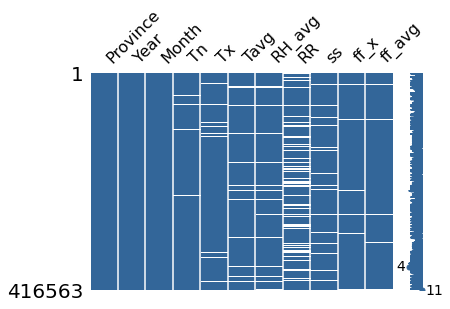

In [236]:
weatherdf.info() #check datatype
weatherdf.isnull().sum() #check null
weatherdf.describe()

msno.matrix(weatherdf, figsize=(6,4),color=(0.2, 0.4, 0.6))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2380 entries, 0 to 2379
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Province      2380 non-null   object 
 1   Crop          2380 non-null   object 
 2   Year          2380 non-null   object 
 3   Productivity  2295 non-null   float64
dtypes: float64(1), object(3)
memory usage: 74.5+ KB


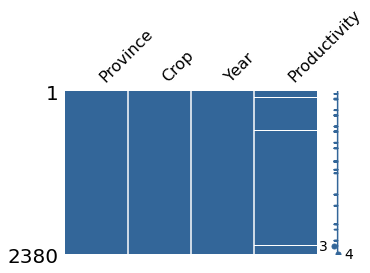

Province        0.000000
Crop            0.000000
Year            0.000000
Productivity    3.571429
dtype: float64


In [237]:
crop_prod_2010_2017_df.info() #check datatype
crop_prod_2010_2017_df.isnull().sum() #check null


# Visualize missing data as a matrix
msno.matrix(crop_prod_2010_2017_df, figsize=(5, 3), color=(0.2, 0.4, 0.6))
plt.show()

# Calculate the percentage of missing data for each column
missing_percentage = crop_prod_2010_2017_df.isnull().mean() * 100
print(missing_percentage)

The matrixs show the locations of missing data within the DataFrame.

The data type of "Year" in **crop_prod_2010_2017_df** should not be object.

In [238]:
crop_prod_2010_2017_df['Year'] = pd.to_numeric(crop_prod_2010_2017_df['Year'], errors='coerce')
crop_prod_2010_2017_df.info() #check datatype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2380 entries, 0 to 2379
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Province      2380 non-null   object 
 1   Crop          2380 non-null   object 
 2   Year          2380 non-null   int64  
 3   Productivity  2295 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 74.5+ KB


## Handle Missing Values

To handle missing values in the weather dataset, fills missing values using their monthly averages.

For **RR**, it is likely that the NaN datas are actually days that it did not rain



In [239]:
# Fill missing values with monthly averages
weatherdf['Tn'] = weatherdf.groupby('Month')['Tn'].transform(lambda x: x.fillna(x.mean()))
weatherdf['Tx'] = weatherdf.groupby('Month')['Tx'].transform(lambda x: x.fillna(x.mean()))
weatherdf['Tavg'] = weatherdf.groupby('Month')['Tavg'].transform(lambda x: x.fillna(x.mean()))
weatherdf['RH_avg'] = weatherdf.groupby('Month')['RH_avg'].transform(lambda x: x.fillna(x.mean()))
weatherdf['ss'] = weatherdf.groupby('Month')['ss'].transform(lambda x: x.fillna(x.mean()))
weatherdf['ff_x'] = weatherdf.groupby('Month')['ff_x'].transform(lambda x: x.fillna(x.mean()))
weatherdf['ff_avg'] = weatherdf.groupby('Month')['ff_avg'].transform(lambda x: x.fillna(x.mean()))

# Fill in missing values for rainfall to be 0 as it is likely that it did not rain hence there is no data
weatherdf['RR'] = weatherdf['RR'].fillna(0)

# Create column of interest: T_diff
weatherdf['T_diff'] = weatherdf['Tx'] - weatherdf['Tn']
weatherdf = weatherdf[['Province', 'Year', 'Month', 'Tn', 'Tx', 'Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']]

# Check for remaining missing values
weatherdf.isnull().sum()

Province    0
Year        0
Month       0
Tn          0
Tx          0
Tavg        0
T_diff      0
RH_avg      0
RR          0
ss          0
ff_x        0
ff_avg      0
dtype: int64

To handle missing values in the crop dataset, we will drop the rows with missing data. This mean we are removing a certain crop productivity of a certain year from its province. We can't simply impute the missing data from other provinces as we want to analyse the local crop productivity. Also, the percentage of missing data is low at less than 5%. Hence, dropping rows is unlikely to significantly impact the analysis or the insights derived from the data.


In [240]:
# Drop rows where there is missing data
crop_prod_2010_2017_df = crop_prod_2010_2017_df.dropna()

## Descriptive Statistics Analysis

In [241]:
# descriptive statistics
weatherdf.describe()

,Year,Month,Tn,Tx,Tavg,T_diff,RH_avg,RR,ss,ff_x,ff_avg
count,416563.000000,416563.000000,416563.000000,416563.000000,416563.000000,416563.00000,416563.000000,416563.000000,416563.000000,416563.000000,416563.000000
mean,2013.494653,6.505026,23.267555,31.471835,26.808115,8.20428,82.540128,6.995672,4.843036,4.787695,2.036079
std,2.362508,3.449641,2.270320,2.122851,1.889295,2.30441,6.499006,16.737165,2.904331,2.811208,1.949691
min,2010.000000,1.000000,0.000000,0.000000,0.000000,-212.60000,24.000000,-1.000000,0.000000,0.000000,0.000000
25%,2011.000000,4.000000,23.000000,30.600000,26.200000,6.80000,79.000000,0.000000,2.600000,3.000000,1.000000
50%,2014.000000,7.000000,24.000000,31.600000,27.000000,8.20000,83.000000,0.000000,4.918503,4.000000,2.000000
75%,2016.000000,10.000000,25.000000,32.800000,27.900000,9.60000,87.000000,6.000000,7.200000,6.000000,3.000000
max,2017.000000,12.000000,246.000000,92.000000,141.600000,69.00000,432.000000,1965.500000,99.000000,185.000000,86.000000


### Weather Data

**Tn**, **Tx** and **Tavg** contain minimum and maximum temperature values that are clearly incorrect, as temperatures in Indonesia do not drop to 0°C, and the recorded maximum temperatures exceed realistic levels.

**RH_avg** with the maximum value far beyond the possible range for humidity (humidity should be within 0% to 100%).

**RR** minimum value is -1 mm, which is not possible for rainfall. Rainfall values must be non-negative. Its' maximum value is 1965.5 mm. While rare, this could indicate an extreme weather event, but we cross-checked with historical data and found no such event.

**ss** maximum value is 705 hours, which is unrealistic as it exceeds the total hours in a month.

**ff_x** maximum value is 185 m/s, which is extremely high and would classify as a catastrophic wind event (e.g., a super typhoon). We cross-checked with historical data and find no such event, the highest wind speeds recored in Indonesia only reach up to 250 km/h or 70 m/s in a typhoon.

**ff_avg** maximum value is 160 m/s, which is unrealistically high and exceeds the highest wind speed recorded in Indonesia.

These anomalies are likely data entry errors and will be addressed through outlier detection methods.


In [242]:
# Describe for each crop, ignoring 'Province' and 'Year'
crop_descriptions = crop_prod_2010_2017_df.drop(columns=['Province', 'Year']).groupby('Crop').describe()
crop_descriptions.round(2)

Productivity                                                      
                   count    mean    std    min     25%     50%     75%     max
Crop                                                                          
Cassava            331.0  194.73  69.76   0.00  132.02  191.45  235.63  426.49
Maize              331.0   40.83  14.90   0.00   27.85   39.50   51.20   81.68
Mungbean           312.0   10.40   2.21   0.00    8.98   10.71   11.78   14.53
Paddy              337.0   45.49   9.31  22.79   39.25   46.96   51.74   62.14
Peanut             331.0   11.92   2.09   0.00   10.60   11.85   13.10   18.45
Soybean            325.0   12.99   2.38   0.00   11.36   12.94   14.61   19.47
SweetPotato        328.0  129.70  54.66   0.00   96.70  112.67  143.11  316.18

### Crop Data

**Cassava** has the highest mean productivity (157.01 quintals/hectare), and **Sweet Potato** follows with 105.75 quintals/hectare. This could be due to these crops' inherent ability to thrive under diverse conditions.

**Cassava** and **Sweet Potato** also have high standard deviations (58.44 and 46.49, respectively), indicating a wide range of productivity levels across provinces and years. This could suggest variability due to environmental factors or farming practices.

Several crops (**Cassava, Maize, Mungbean, Peanut, Soybean, Sweet Potato**) have a minimum productivity of 0. This indicates instances where no yield was recorded for certain province or years.

Crops like **Mungbean, Peanut, and Soybean** have relatively low standard deviations (~2 quintals/hectare). This suggests consistency in productivity across provinces and years.

**Mungbean** and **Peanut**  have the lowest mean productivity among all crops.

**Cassava** has a maximum productivity of 397.66 quintals/hectare, far exceeding the 75th percentile (202.96). **Sweet Potato** also shows an extreme maximum (316.18 quintals/hectare). These are potential outliers and could indicate exceptional performance in certain provinces due to ideal conditions or data entry errors. 

Upon further investigation, there are more than 1 such extreme data in both crops. These extreme datas are consistent in year and province

No outlier handling needed for this dataset

## Handle outlier 

We will handle the outliers by setting a boundary for realistic value and replace values outside of the range with the nearest valid boundary

**Tn, Tx, Tavg**: the typical temperature range for Indonesia is 10°C–40°C . 

**RH_avg**: humidity values can only be 0% to 100%.

**RR**: the lower bound is 0mm for rainfall and we use the 99th percentile as the upperbound to ensure no extreme values

**ss**: sunshine duration should be 0 (cloudy day) to 0.8 

**ff_x, ff_avg**: minimum wind speed is 0 m/s and maximum at 70 m/s based on historical maximums

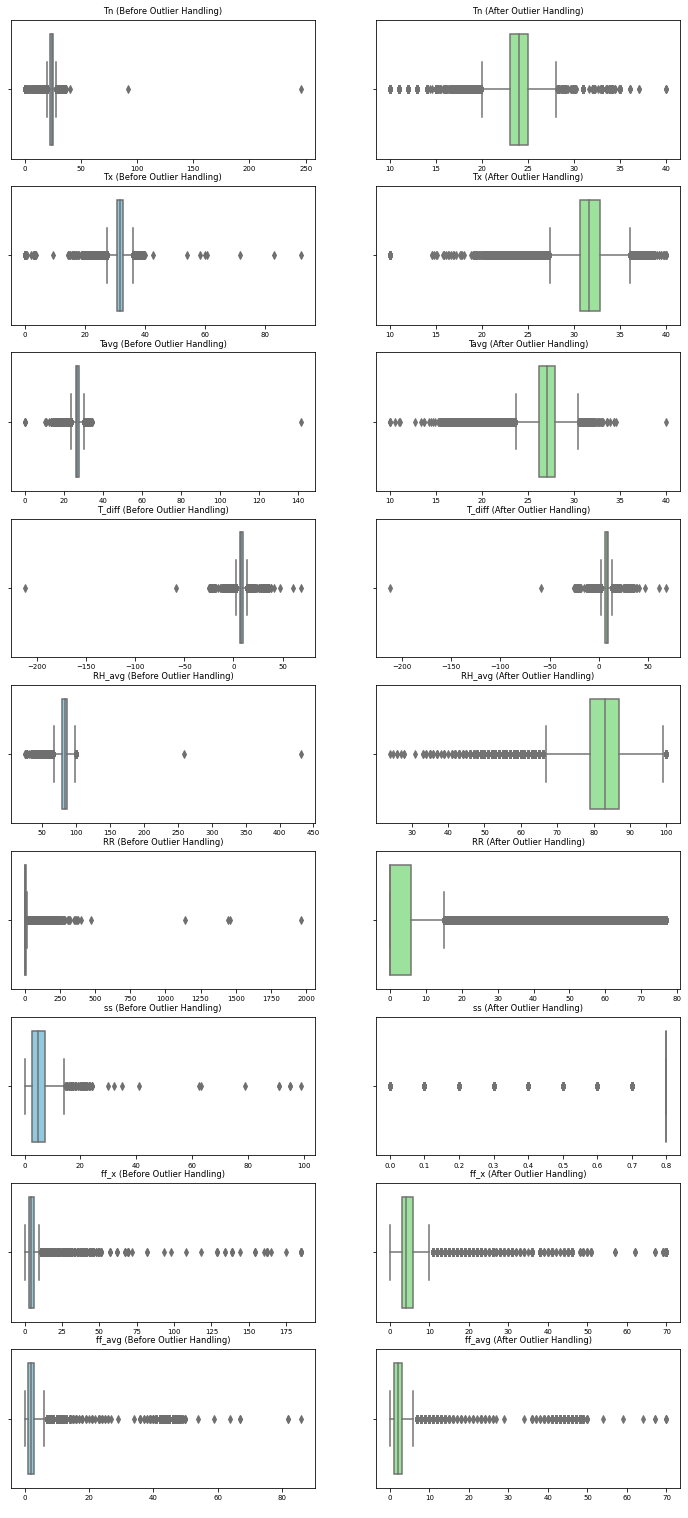

In [243]:
original_weatherdf = weatherdf.copy()

# Handle temperature outliers
weatherdf['Tn'] = weatherdf['Tn'].clip(lower=10, upper=40)
weatherdf['Tx'] = weatherdf['Tx'].clip(lower=10, upper=40)
weatherdf['Tavg'] = weatherdf['Tavg'].clip(lower=10, upper=40)

# Handle humidity outliers
weatherdf['RH_avg'] = weatherdf['RH_avg'].clip(lower=0, upper=100)

# Handle rainfall outliers
rr_upper = weatherdf['RR'].quantile(0.99)
weatherdf['RR'] = weatherdf['RR'].clip(lower=0, upper=rr_upper)

# Handle sunshine duration outliers
weatherdf['ss'] = weatherdf['ss'].clip(lower=0, upper=0.8)

# Handle wind speed outliers
weatherdf['ff_x'] = weatherdf['ff_x'].clip(lower=0, upper=70)
weatherdf['ff_avg'] = weatherdf['ff_avg'].clip(lower=0, upper=70)


columns_to_plot = ['Tn', 'Tx', 'Tavg','T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']

# Plot before and after outlier handling
fig, axes = plt.subplots(len(columns_to_plot), 2, figsize=(12, len(columns_to_plot) * 3))

for i, column in enumerate(columns_to_plot):
    # Boxplot before handling outliers
    sns.boxplot(data=original_weatherdf, x=column, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'{column} (Before Outlier Handling)')
    axes[i, 0].set_xlabel(' ')

    # Boxplot after handling outliers
    sns.boxplot(data=weatherdf, x=column, ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'{column} (After Outlier Handling)')
    axes[i, 1].set_xlabel(' ')

Now that we are done with processing all the dataset, we want to merge the weather data and the crop productivity data together

In [244]:
weatherdf_copy = weatherdf.copy()
crop_prod_2010_2017_df_copy = crop_prod_2010_2017_df.copy()

# Group by Province, Year, and Month, then calculate the mean for each group
weatherdf_copy = weatherdf_copy.groupby(['Province', 'Year', 'Month']).mean().reset_index()
weatherdf_copy = weatherdf_copy.round(2)

# Merge weatherdf_copy and crop_prod_2010_2017_df_copy on Province and Year
weather_productivitydf = pd.merge(weatherdf_copy, crop_prod_2010_2017_df_copy, on=['Province', 'Year'], how='inner')

# Drop Tn and Tx columns
weather_productivitydf = weather_productivitydf.drop(columns=['Tn', 'Tx'])

# Display the combined dataframe
display(weather_productivitydf)

,Province,Year,Month,Tavg,T_diff,RH_avg,RR,ss,ff_x,ff_avg,Crop,Productivity
0,aceh,2010,1,25.89,9.50,83.18,5.77,0.61,5.1,2.20,Cassava,142.06
1,aceh,2010,1,25.89,9.50,83.18,5.77,0.61,5.1,2.20,Maize,38.07
2,aceh,2010,1,25.89,9.50,83.18,5.77,0.61,5.1,2.20,Mungbean,10.61
3,aceh,2010,1,25.89,9.50,83.18,5.77,0.61,5.1,2.20,Paddy,44.92
4,aceh,2010,1,25.89,9.50,83.18,5.77,0.61,5.1,2.20,Peanut,12.66
...,...,...,...,...,...,...,...,...,...,...,...,...
27031,yogyakarta,2017,12,26.32,8.17,87.23,10.61,0.77,2.1,0.57,Mungbean,5.80
27032,yogyakarta,2017,12,26.32,8.17,87.23,10.61,0.77,2.1,0.57,Paddy,55.48
27033,yogyakarta,2017,12,26.32,8.17,87.23,10.61,0.77,2.1,0.57,Peanut,11.74
27034,yogyakarta,2017,12,26.32,8.17,87.23,10.61,0.77,2.1,0.57,Soybean,13.25


## Visualization with analysis

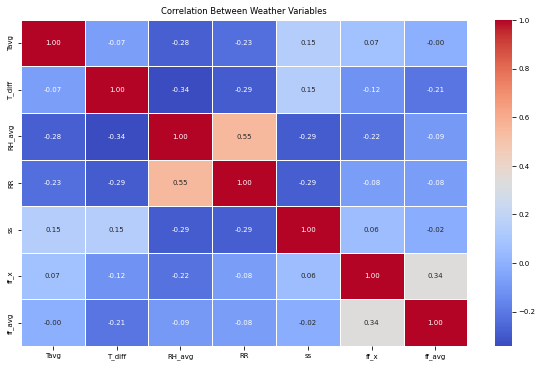

In [245]:
# Correlation Between Weather Variables
corr_matrix = weather_productivitydf[['Tavg','T_diff','RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']].corr()
plt.figure(figsize=(10, 6))  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Weather Variables')
plt.show()


The graph is correaltion heatmap that visualizes the relationship between various weather variables. 
The correlation coefficient ranges from -1 to 1. 
**correlation coefficient**

A value of 1 indicates a perfect correlation

a value of -1 shoes a perfect negative correlation. 

A value of 0 shows that there is no correlation.

**colour scale representation**

Blue represents negative correlation. 

Red represents positive correlations

The negative correlation between temperature and humidity aligns with our general understanding that hotter air tends to hold less moiture. Furthermore,
there is a positive correlation between sunshine hours and temperature suggests that warmer days tend to have more sunlight. Similarly, there is also a positive coreleation between rainfall and humidity because higher humidity increases the chance of precipitation. It is observed that there is no correlation between wind speeds and other variables, indicating that windspeed are independent to the rest of the variables. 

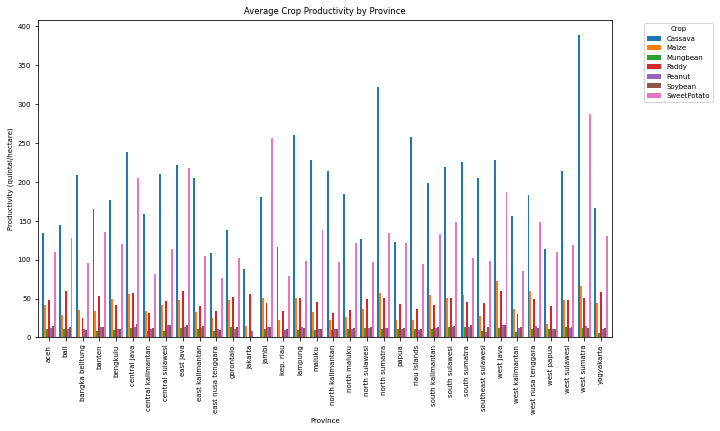

In [246]:
# visualise crop productivity by each province
mean_productivity = crop_prod_2010_2017_df.groupby(['Province', 'Crop'])['Productivity'].mean().reset_index()
pivot_df = mean_productivity.pivot(index='Province', columns='Crop', values='Productivity')
pivot_df.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Average Crop Productivity by Province')
plt.xlabel('Province')
plt.ylabel('Productivity (quintal/hectare)')
plt.legend(title='Crop', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The bar chart visualises the average crop productivity(quintals/hectare) for various crops across provinces in Indonesia. We can observe that 'Cassava' consistently shows the highest productivity followed by 'Sweet Potato', especially in 'West Sumatra'. This suggests it may be a reliable crop in terms of yield and adaptability to various environmental conditions. 

In contrast, 'Mungbean' and 'Peanut' demonstrate lower productivity across all provinces which may indicate challenges in growing them consistently.

'Maize', 'Paddy' and 'Soybean' show steady but moderate productivity, reflecting their widespread cultivation and the government's focus on them as staple crops.

Regional disparities in productivity emphasises the need for province-specific strategies as some areas outperform others due to factors such as differences in climate, resources or practices.

The line chart represents the paddy productivity(quintals/hectare) while the bar chart represents the rainfall(mm). We can infer that higher rainfall generally leads to higher yields, especially in provinces like 'West Java' and 'Central Java. Provinces like 'East Nusa Tenggara' have low rainfall and low productivity, aligning with the general trend. These areas may face challenges related to water scarcity or could be less suitable for rice farming. 

Provinces with high productivity despite moderate rainfall like 'Jakarta' could indicate the possible role of advanced farming techniques, irrigation systems or soil quality.

However, there are inconsistencies where high rainfall does not necessarily lead to high productivity in provinces such as 'West Sumatra'. This indicates the possible influence of non-climatic factors like crop management.

While rainfall is an important factor in influencing paddy productivity, variations in productivity highlights the need for province-specific interventions such as improving irrigation, access to fertilizers or training on advanced farming techniques.

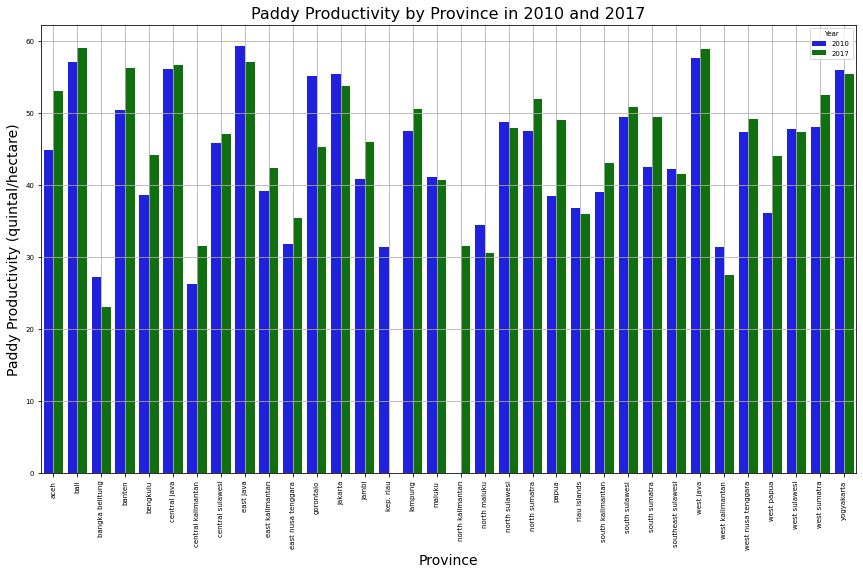

In [247]:
# Filter paddy production data for 2010 and 2017
paddy_data = crop_prod_2010_2017_df[
    (crop_prod_2010_2017_df['Crop'] == 'Paddy') & 
    (crop_prod_2010_2017_df['Year'].isin([2010, 2017]))
]

# Calculate average paddy productivity per province for each year
avg_paddy_prod = paddy_data.groupby(['Province', 'Year'])['Productivity'].mean().reset_index()

# Plotting the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='Province', y='Productivity', hue='Year', data=avg_paddy_prod, palette={2010: 'blue', 2017: 'green'})
plt.xlabel('Province', fontsize=14)
plt.ylabel('Paddy Productivity (quintal/hectare)', fontsize=14)
plt.title('Paddy Productivity by Province in 2010 and 2017', fontsize=16)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


The bar graph shows paddy production across different provinces for the years 2010 and 2010. The data is grouped by provinces, with each bar representing the average productivity for a given year. In most provinces, the production of paddy in 2017 is more than the production in 2010 indicating there is an increase in the productivity over the seven-year period. Some provinces may show litlle change or even a decline, suggesting region-specific factors affecting the crop yield. Factors that might have affected the increase or decrease in the data include climate impact, technological advancements, soil and resource constraints. 

**Climate Impact** : rainfall and temperature over the years might have influenced the productivity.

**Technological Advancement**: Introduction of better seeds, irrifation systems and farming techniques explains the increase in productivity in 2017. 

**Soil and Resource Constraints**: Low-performing provinces may face soil degration or lack of water.

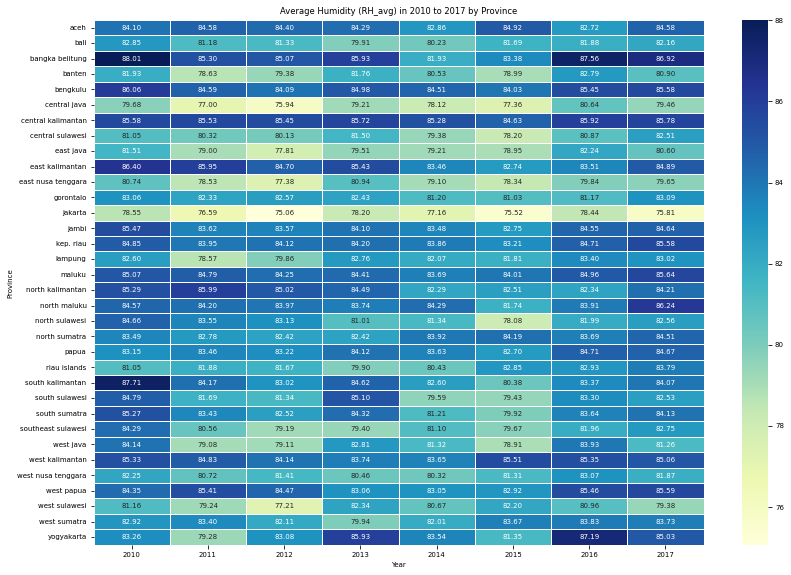

In [248]:
humidity_data = weatherdf[weatherdf['Year'].isin(range(2010, 2018))]
avg_humidity = humidity_data.groupby(['Province', 'Year'])['RH_avg'].mean().reset_index()
pivot_data = avg_humidity.pivot(index='Province', columns='Year', values='RH_avg')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.xlabel('Year')
plt.ylabel('Province')
plt.title('Average Humidity (RH_avg) in 2010 to 2017 by Province')
plt.tight_layout()
plt.show()


The heatmap visualize the average humidity for the years 2010 to 2017, grouped by province. The heatmap clearly shows that the humidity levels vary across provinces. Some provinces consistently have high humidity while others have lower humidity. Provinces with consistently high humidiity levels may be areas that are coastal or have a tropical climate. These provinces likely have more rainfall or may have forests or wetlands. On the other hand, provinces with prodominantly yellow or light blue could be experiencing drier weather. potentially due to seasonal drouhgts. Inconsistent or fluctuating humidity may also indicate that irregular weather pattens or local environmental change such as deforestation or changes in irrigation. 


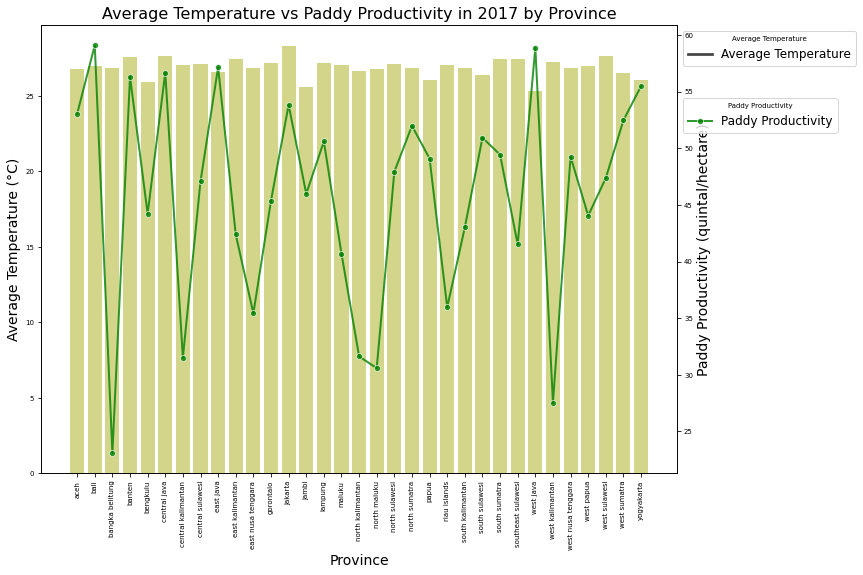

In [249]:
# Filter temperature data for 2017
temperature_data = weatherdf[weatherdf['Year'] == 2017]
avg_temperature = temperature_data.groupby(['Province', 'Year'])['Tavg'].mean().reset_index()

# Filter paddy production data for 2017
paddy_data = crop_prod_2010_2017_df[
    (crop_prod_2010_2017_df['Crop'] == 'Paddy') & 
    (crop_prod_2010_2017_df['Year'] == 2017)
]

# Calculate average paddy productivity per province for 2017
avg_paddy_prod = paddy_data.groupby(['Province', 'Year'])['Productivity'].mean().reset_index()

# Merge average temperature and paddy productivity data for 2017
merged_data = pd.merge(avg_temperature, avg_paddy_prod, on=['Province', 'Year'], how='inner')

# Plot average temperature and paddy productivity for 2017
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for Average Temperature
sns.barplot(x='Province', y='Tavg', data=merged_data, ax=ax1, color='#d1d646', alpha=0.7)
ax1.set_ylabel('Average Temperature (°C)', fontsize=14)
ax1.set_xlabel('Province', fontsize=14)
ax1.set_title('Average Temperature vs Paddy Productivity in 2017 by Province', fontsize=16)
ax1.tick_params(axis='x', rotation=90)

# Line plot for Paddy Productivity
ax2 = ax1.twinx()
sns.lineplot(x='Province', y='Productivity', data=merged_data, ax=ax2, marker='o', linewidth=2, color='#008000', alpha=0.8)
ax2.set_ylabel('Paddy Productivity (quintal/hectare)', fontsize=14)

# Legends
ax1.legend(['Average Temperature'], loc='upper left', bbox_to_anchor=(1, 1), title='Average Temperature', fontsize=12)
ax2.legend(['Paddy Productivity'], loc='upper left', bbox_to_anchor=(1, 0.85), title='Paddy Productivity', fontsize=12)

plt.tight_layout()
plt.show()


The graph shows the comparison between termperature and paddy production in the years 2008-2010. Some provinces experiences higher temperature while others have a lower temperature. These difference can be influenced by climate variation, seasonal fluctuation or anomalies in temperature due to events like El Nino or La Nina. In general, we may observe whether higher temperature corresponds with higher paddy production. A province experiences high temperature , it shows an increase in paddy production, indicating that temperature positively impacts crop yield. Alternatively, if a province with high rtemperature does not show corresponding high productivity, it may suggest that there are other factors, such as soil quality or pest infestation, limiting the yield. 

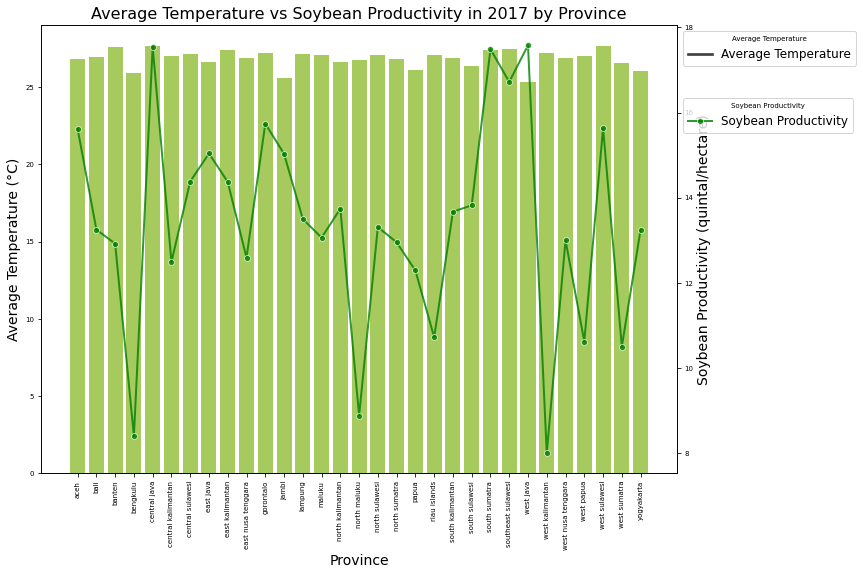

In [250]:
# Filter temperature data for 2017
temperature_data = weatherdf[weatherdf['Year'] == 2017]
avg_temperature = temperature_data.groupby(['Province', 'Year'])['Tavg'].mean().reset_index()

# Filter soybean production data for 2017
soybean_data = crop_prod_2010_2017_df[
    (crop_prod_2010_2017_df['Crop'] == 'Soybean') & 
    (crop_prod_2010_2017_df['Year'] == 2017)
]

# Calculate average soybean productivity per province for 2017
avg_soybean_prod = soybean_data.groupby(['Province', 'Year'])['Productivity'].mean().reset_index()

# Merge average temperature and soybean productivity data for 2017
merged_data = pd.merge(avg_temperature, avg_soybean_prod, on=['Province', 'Year'], how='inner')

# Plot average temperature and soybean productivity for 2017
fig, ax1 = plt.subplots(figsize=(12, 8))

# Bar plot for Average Temperature
sns.barplot(x='Province', y='Tavg', data=merged_data, ax=ax1, color='#8ACE00', alpha=0.7)
ax1.set_ylabel('Average Temperature (°C)', fontsize=14)
ax1.set_xlabel('Province', fontsize=14)
ax1.set_title('Average Temperature vs Soybean Productivity in 2017 by Province', fontsize=16)
ax1.tick_params(axis='x', rotation=90)

# Line plot for Soybean Productivity
ax2 = ax1.twinx()
sns.lineplot(x='Province', y='Productivity', data=merged_data, ax=ax2, marker='o', linewidth=2, color='#008000', alpha=0.8)
ax2.set_ylabel('Soybean Productivity (quintal/hectare)', fontsize=14)

# Legends
ax1.legend(['Average Temperature'], loc='upper left', bbox_to_anchor=(1, 1), title='Average Temperature', fontsize=12)
ax2.legend(['Soybean Productivity'], loc='upper left', bbox_to_anchor=(1, 0.85), title='Soybean Productivity', fontsize=12)

plt.tight_layout()
plt.show()


The line chart represents the soybean productivity(quintal/hectare) while the bar chart represents the average temperature(°C). The average temperature remains relatively stable, ranging between 25°C for most provinces. The stability indicates that temperature differences are unlikely to be a significant factor affecting soybean productivity. Out of all the provinces, 'West Sumatra' and 'Central Java' display the highest yields while 'Bangka Belitung' displays the lowest yield. 

Despite consistent temperature ranges, soybean productivity does not show a strong correlation with temperature. This suggests that other factors such as soil conditions, farming techniques or water availability may play a larger role in determining soybean yields.

## Correlation analysis

Since there are multiple crops for us to model, we will choose one crop for this project. The analysis process can be replicated for other crops
The crop we are choosing is: **paddy**, the main crop, a critical staple food, and the source of livelihood for millions of farmers in Indonesia.

In [251]:
# Choose Paddy as the crop for analysis
paddy_df_12 = weather_productivitydf[weather_productivitydf['Crop'] == 'Paddy']

# our the problems statement only look at the first 6 month weather variables
paddy_df = paddy_df_12[paddy_df_12['Month'].isin([1, 2, 3, 4, 5, 6])]
paddy_df = paddy_df.reset_index(drop=True)

display(paddy_df)

,Province,Year,Month,Tavg,T_diff,RH_avg,RR,ss,ff_x,ff_avg,Crop,Productivity
0,aceh,2010,1,25.89,9.50,83.18,5.77,0.61,5.10,2.20,Paddy,44.92
1,aceh,2010,2,25.89,9.04,84.84,6.78,0.56,4.52,2.14,Paddy,44.92
2,aceh,2010,3,25.97,8.96,85.23,5.83,0.57,4.08,1.77,Paddy,44.92
3,aceh,2010,4,26.57,9.03,85.07,7.96,0.61,4.89,1.95,Paddy,44.92
4,aceh,2010,5,27.25,9.34,83.54,4.79,0.60,5.49,2.23,Paddy,44.92
...,...,...,...,...,...,...,...,...,...,...,...,...
1979,yogyakarta,2017,2,26.45,8.31,84.50,6.88,0.78,2.75,1.22,Paddy,55.48
1980,yogyakarta,2017,3,26.08,8.03,85.79,8.49,0.73,2.78,1.02,Paddy,55.48
1981,yogyakarta,2017,4,25.78,8.14,84.00,6.76,0.65,2.92,1.10,Paddy,55.48
1982,yogyakarta,2017,5,25.17,8.54,82.61,1.85,0.77,2.14,0.92,Paddy,55.48


In [252]:
correlation_scores = {}

for province_name, province_data in paddy_df.groupby('Province'):
    corr_matrix = province_data[['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg', 'Productivity']].corr()
    if 'Productivity' in corr_matrix:
        # Mean absolute correlation with Productivity
        productivity_corr = corr_matrix['Productivity'].drop('Productivity', errors='ignore').abs().mean()  
        correlation_scores[province_name] = productivity_corr

# Sort provinces by the average correlation score in descending order
top_provinces = sorted(correlation_scores.items(), key=lambda x: x[1], reverse=True)[:10]

# Extract top provinces based on the mean correlation
top_provinces_df = pd.DataFrame(top_provinces, columns=['Province', 'Avg_Correlation'])

top_10_province_names = top_provinces_df['Province'].tolist()

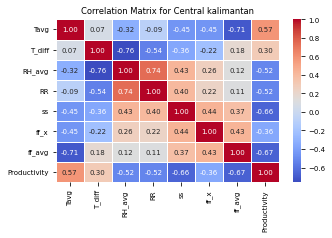

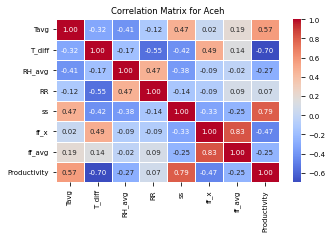

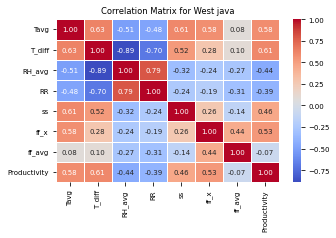

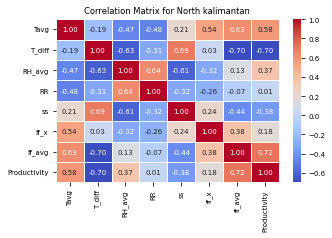

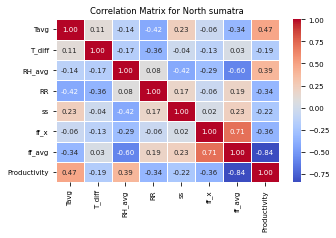

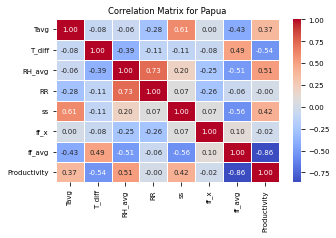

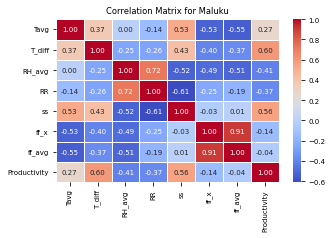

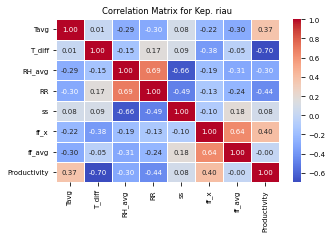

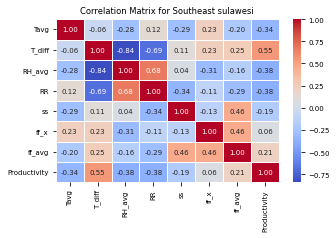

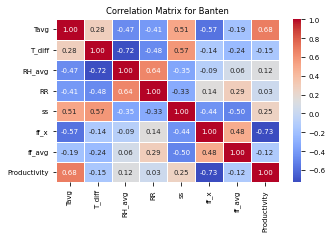

In [253]:
# plot correlation heatmap for the top 10 highest paddy productivity correlation provinces
for province_name in top_10_province_names:
    province_data = paddy_df[paddy_df["Province"] == province_name]
    corr_matrix_province = province_data[['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg', 'Productivity']].corr()
    plt.figure(figsize=(5, 3))
    sns.heatmap(corr_matrix_province, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix for {province_name.capitalize()}')
    plt.show()

# Features and Target Preparation

Prepare features and target for model training.

We will train 1 model for each of these provinces to capture the unique climatic characteristics influencing paddy yield productivity. By segmenting the provinces, we can ensure that our models are tailored to localised conditions, leading to more accurate insights.
We will be making models for 5 provinces in this project because allows us to focus on creating detailed, province-specific analyses while managing the scope and complexity of the project. However, it is definitely possible to develop models for all 34 provinces if given more time and resources.

We will choose 5 out of the top 10 mean correlation score above with the additional selection criterias which are agricultural diversity, geographical diversity, economic and cultural significance provinces.

Aceh:

- Coastal and rain-fed agricultural systems.
- Historically significant for traditional farming practices in Sumatra.

Central Kalimantan:

- Represents the wetland and peatland agriculture of Borneo.
- Significant for its traditional farming practices and environmental challenges related to peatland management.

Banten:

- Represents a region with coastal and inland rice farming.
- Mix of modern and traditional agricultural practices.

North Sumatra:

- One of Indonesia's most agriculturally diverse regions, with extensive rice cultivation and mixed farming systems.
- Represents the western region's dynamic mix of highland and lowland agriculture.

Papua:

- Represents Indonesia’s easternmost and least developed region.
- Geographically diverse, with highlands and tropical rainforests.

we will start with Central Kalimantan model first

In [254]:
province_dfs = {}

for province in top_10_province_names:
    province_dfs[province] = paddy_df[paddy_df['Province'] == province]

In [255]:
def get_features_targets(df: pd.DataFrame, 
                         feature_names: list[str], 
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_feature = df.loc[: , feature_names]
    df_target = df.loc[: , target_names]
    return df_feature, df_target

def normalize_z(array: np.ndarray, 
                columns_means: Optional[np.ndarray]=None, 
                columns_stds: Optional[np.ndarray]=None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if columns_means is None:
        columns_means = array.mean(axis=0)
    if columns_stds is None:
        columns_stds = array.std(axis=0)
    out:np.ndarray = (array - columns_means) / columns_stds
    return out, columns_means, columns_stds

def prepare_feature(np_feature: np.ndarray) -> np.ndarray:
    m,_ = np_feature.shape
    x0 = np.ones((m, 1))
    return np.concatenate((x0, np_feature), axis=1)

def transform_features(df_feature: pd.DataFrame, 
                       colname: str, 
                       colname_transformed: str) -> pd.DataFrame:
    
    df_feature[colname_transformed] = df_feature[colname] ** 2
    return df_feature


In [256]:
# preparing the features and target for central kalimantan model 
df_feature, df_target = get_features_targets(province_dfs['central kalimantan'], ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])

# Building Model

In [257]:
def calc_linreg(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    return np.matmul(X, beta)

def compute_cost_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    y_hat = calc_linreg(X, beta)
    m, _ = X.shape
    J = np.sum((y_hat - y)**2) / (2 * m)

    return np.squeeze(J)

def gradient_descent_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray, 
                            alpha: float, num_iters: int) -> tuple[np.ndarray, np.ndarray]:
    J_storage=np.zeros((num_iters, 1))
    m, _=X.shape
    for i in range(0, num_iters):
        cost=compute_cost_linreg(X, y, beta)
        J_storage[i] = cost
        y_hat = calc_linreg(X, beta)
        beta = beta-(alpha/m)*(np.matmul(X.T, (y_hat-y)))
    return beta, J_storage
    
def predict_linreg(array_feature: np.ndarray, beta: np.ndarray, 
                   means: Optional[np.ndarray]=None, 
                   stds: Optional[np.ndarray]=None) -> np.ndarray:
    #apply norm_z to array features
    if (means is None) or stds is None:
        norm_array,_,_ = normalize_z(array_feature)
    else:
        norm_array,_,_ = normalize_z(array_feature, means, stds)
    X_test = prepare_feature(norm_array)
    return calc_linreg(X_test, beta)

def build_model_linreg(df_feature_train: pd.DataFrame,
                       df_target_train: pd.DataFrame,
                       beta: Optional[np.ndarray] = None,
                       alpha: float = 0.01,
                       iterations: int = 1500) -> tuple[dict[str, Any], np.ndarray]:
    if beta is None:
        beta = np.zeros((df_feature_train.shape[1] + 1, 1)) 
    assert beta.shape == (df_feature_train.shape[1] + 1, 1)
    model: dict[str, Any] = {}

    # normalise features and get its output as numpy array 
    array_feature_train_z, means, stds = normalize_z(df_feature_train.to_numpy()) 
    
    # prepare feature matrix X and target vector as numpy arrays 
    X = prepare_feature(array_feature_train_z)
    target = df_target_train.to_numpy() 

    beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)

    model = {"beta": beta, "means": means, "stds": stds}
    return model, J_storage

In [258]:
def split_data(df_feature: pd.DataFrame, df_target: pd.DataFrame, 
               random_state: Optional[int]=None, 
               test_size: float=0.5) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    indexes: pd.Index = df_feature.index
    if random_state != None:
        np.random.seed(random_state)
    k: int = int(test_size*len(indexes))
    test_index: pd.Index = np.random.choice(indexes, k, replace = False)
    train_index: pd.Index = indexes.drop(test_index)
    df_feature_train: pd.DataFrame = df_feature.loc[train_index, :]
    df_feature_test: pd.DataFrame = df_feature.loc[test_index, :]
    df_target_train: pd.DataFrame = df_target.loc[train_index, :]
    df_target_test: pd.DataFrame = df_target.loc[test_index, :]
    return df_feature_train, df_feature_test, df_target_train, df_target_test

In [259]:
# splitting the dataset into training set and test set
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)

# the function to build linear regression model return the dictionary 'model' which contain the learned parameter (beta)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model

{'beta': array([[31.91689571],
        [ 0.23244855],
        [-0.06704243],
        [-0.42551211],
        [-0.78818267],
        [-1.16257597],
        [ 0.5043072 ],
        [-1.47654854]]),
 'means': array([27.06214286,  9.55      , 84.51857143,  6.11571429,  0.70404762,
         3.99714286,  1.59595238]),
 'stds': array([0.24611782, 0.41115401, 1.17052404, 2.5720412 , 0.07874188,
        0.39640819, 0.37373316])}

# Evaluating the Model

Since we have multiple predictors, R^2 will increase even if the predictors don’t improve the model. Hence we will adjust R-squared by accounting for the number of predictors relative to the data size. This will prevent overestimation of the model's performance.

$$
\text{Adjusted } R^2 = 1 - \frac{(1 - R^2)(N - 1)}{N - p - 1}
$$


In [260]:
def r2_score(y: np.ndarray, ypred: np.ndarray) -> float:
    ss_res = np.sum((y - ypred) ** 2)
    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean) ** 2)
    return 1 - (ss_res / ss_tot)

def adjusted_r2_score(y: np.ndarray, ypred: np.ndarray, n: int, p: int) -> float:
    r2 = r2_score(y, ypred)
    return 1 -((1 - r2) * (n - 1))/ (n - p - 1)

def mean_squared_error(target: np.ndarray, pred: np.ndarray) -> float:
    return np.mean((target-pred)**2)

In [261]:
beta: np.ndarray = model['beta'] 
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)

target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)

mse: float = mean_squared_error(target, pred)

print("Adjusted R2:", round(adjusted_r2, 2))
print("Mean Square Error:", round(mse, 2))

Adjusted R2: 0.44
Mean Square Error: 2.6


### Metric interpretation:
- An adjusted R² value of 0.44 indicates that 44% of the variability in paddy productivity is explained by the model's features after adjusting for the number of predictors.
This suggests the model has moderate explanatory power. We will attempt to improve the model in the section below.

- A Mean Squared Error (MSE) of 2.6 indicates that the average squared difference between predicted and actual productivity values, translating to an average prediction error (RMSE) of approximately 1.61 units. This might seems small but actually matter alot as we use our predicted crop productivity to calculate predicted crop production. 

# Improving the Model

Paddy yield productivity of central kalimantan model has an adjusted R-squared of **0.44** and MSE of **2.60**. It is currently using 'Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg' as features.
There are a few things in the model that we have yet to consider for paddy:
- Lagged weather variables: rice paddy in Indonesia follows 3 cycles. Among 2 of these cycles is within the year while the last one is planted from October to December, and harvests between February to April of the next year. Hence to account for this, we should conside the previous year October to December's weather conditions as features and the next year paddy productivity as the target.
- Check for linear relationship of the weather features vs paddy production
- Use Recursive Feature Elimination (RFE) to iteratively remove less important weather features based on model adjusted R-squared score until only the most useful subset remain.

We will optimise the model in this order, this is because: 
- Lagged Variables come first because they are foundational to the model, reflecting the agricultural cycles.
- Checking Linearity comes next because it determines whether linear regression is a valid modeling choice.
- RFE comes last because it fine-tunes the feature set after ensuring all necessary variables (including lagged ones) are present and appropriately modeled.

In [262]:
# function to create a df for data of the last 3 months from every year the next year 4 months for specific province
def get_oct_apr_df(province: str): 
    paddy_df_1012 = paddy_df_12[paddy_df_12['Month'].isin([10, 11, 12])]
    paddy_df_1012 = paddy_df_1012[paddy_df_1012['Province'] == province]

    paddy_df_1012 = paddy_df_1012.reset_index(drop=True)

    # Increment the 'Year' column by 1 and shift the 'Productivity' column up by 3 rows
    paddy_df_1012['Year'] += 1
    paddy_df_1012['Productivity'] = paddy_df_1012['Productivity'].shift(-3)

    # Drop rows where the Year is 2018
    paddy_df_1012 = paddy_df_1012[paddy_df_1012['Year'] != 2018]

    ckalimantandf = province_dfs[province].copy()
    ckalimantandf = ckalimantandf[ckalimantandf['Month'].isin([1, 2, 3, 4])]

    combined_df = pd.concat([paddy_df_1012, ckalimantandf], ignore_index=True)
    combined_df = combined_df.sort_values(by='Year')

    month_order = [10, 11, 12, 1, 2, 3, 4]
    combined_df['Month'] = pd.Categorical(combined_df['Month'], categories=month_order, ordered=True)
    combined_df = combined_df.sort_values(by=['Year', 'Month'])

    combined_df = combined_df.reset_index(drop=True)
    return combined_df

combined_df = get_oct_apr_df('central kalimantan')
display(combined_df)

df_feature, df_target = get_features_targets(combined_df, ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model


,Province,Year,Month,Tavg,T_diff,RH_avg,RR,ss,ff_x,ff_avg,Crop,Productivity
0,central kalimantan,2010,1,26.91,8.77,87.04,10.47,0.75,3.99,2.29,Paddy,26.27
1,central kalimantan,2010,2,26.57,8.87,86.51,8.51,0.74,3.94,2.31,Paddy,26.27
2,central kalimantan,2010,3,26.61,9.51,85.78,9.41,0.76,4.22,2.26,Paddy,26.27
3,central kalimantan,2010,4,27.10,9.68,84.90,10.67,0.79,4.08,2.27,Paddy,26.27
4,central kalimantan,2011,10,27.41,9.10,85.16,11.05,0.77,3.62,2.23,Paddy,28.49
...,...,...,...,...,...,...,...,...,...,...,...,...
62,central kalimantan,2017,12,27.56,9.04,85.13,5.40,0.75,3.88,1.19,Paddy,31.51
63,central kalimantan,2017,1,26.81,8.63,85.68,5.55,0.76,4.01,1.32,Paddy,31.51
64,central kalimantan,2017,2,26.98,8.36,84.26,3.70,0.74,4.34,1.45,Paddy,31.51
65,central kalimantan,2017,3,27.23,8.78,83.94,7.16,0.77,3.91,1.25,Paddy,31.51


{'beta': array([[31.95743774],
        [-0.03275663],
        [ 0.15095988],
        [ 0.7136006 ],
        [-0.75914123],
        [-1.41057798],
        [ 0.27358102],
        [-1.47434971]]),
 'means': array([27.07914894,  9.41893617, 84.80468085,  6.14468085,  0.71978723,
         3.99021277,  1.56106383]),
 'stds': array([0.2752935 , 0.47601732, 1.25669586, 2.39258238, 0.06840086,
        0.34627802, 0.35161169])}

In [263]:
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.5141488931169882
2.2168315088947823


The first iteration show an increment in adjusted R-squared value to **0.51** and small decrement of **2.22**. This proof that our hypothesis was correct and we took a step in the right direction.

Now, we will check for non-linear relationship of:
- **T_diff** and **ff_x** which has a weak positive and weak negative correlation.
- **Tavg**, **RR**, **ss**, **RH_avg**  which might be benefitial to productivity within a certain range but detrimental outside that range.


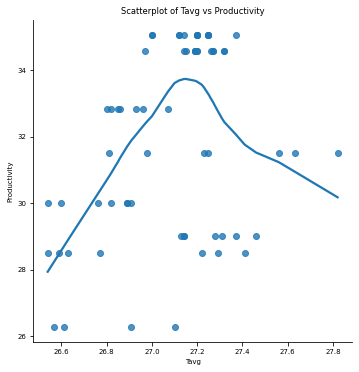

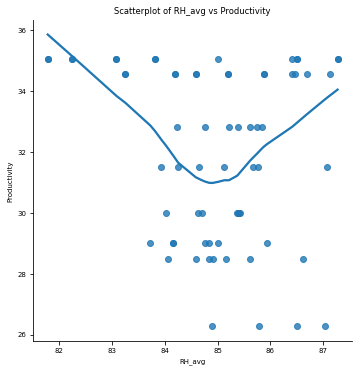

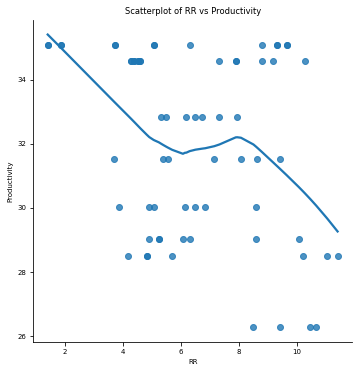

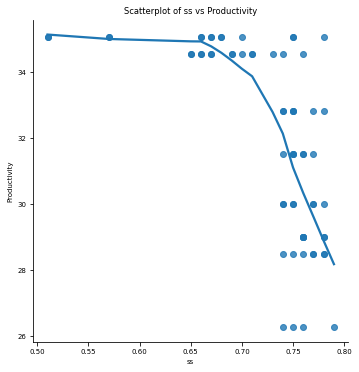

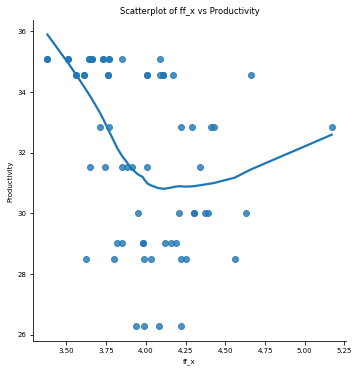

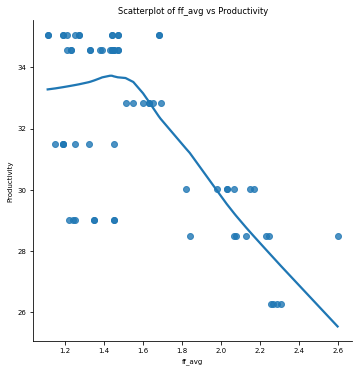

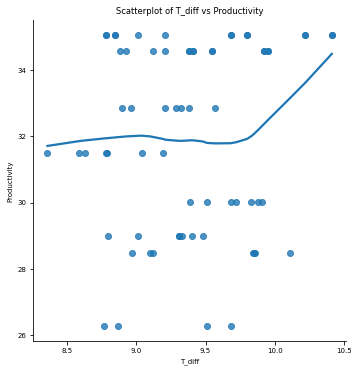

In [264]:
for feature in ['Tavg','RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg', 'T_diff']:
    sns.lmplot(x=feature, y='Productivity', data=combined_df, lowess=True)
    plt.title(f"Scatterplot of {feature} vs Productivity")
    plt.show()

- **RH_avg** shows non-linear relationship.
- **RR** appears mostly linear with a slight non-linear dip around mid-range rainfall values.
- **ss** shows a clear non-linear effect with productivity sharply decreasing beyond a threshold of ~0.7. Sunshine duration has a threshold effect.
- **ff_x** shows non-linear relationship.
- **ff_avg** shows a non-linear negative relationship as productivity decreases sharply beyond a certain threshold (~2.0)
- **T_diff** shows a slight increase at higher temperature differences. This suggests a weak non-linear effect.

We will check for Variance Inflation Factor (VIF) results to see multicollinearity among the transformed features and normal features.
This is because when predictors are highly correlated, their individual effects on the dependent variable become difficult to distinguish thus creates redundancy and instability for our regression model.

In [265]:
combined_df['T_avg^2'] = combined_df['Tavg'] ** 2
combined_df['RH_avg^2'] = combined_df['RH_avg'] ** 2
combined_df['T_diff^2'] = combined_df['T_diff'] ** 2
combined_df['ff_x^2'] = combined_df['ff_x'] ** 2
combined_df['log_ff_avg'] = np.log1p(combined_df['ff_avg'])
combined_df['RR^3'] = combined_df['RR'] ** 3

# we add another column to capture when ss is higher than 0.7, productivity will fall
combined_df['ss_high'] = (combined_df['ss'] > 0.7).astype(int)

# Calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = ['RH_avg^2', 'T_avg^2','T_diff^2','ff_x^2', 'log_ff_avg', 'RR^3','ss_high']
X = combined_df[features]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factors (VIF):")
print(vif_data)

Variance Inflation Factors (VIF):
      Feature          VIF
0    RH_avg^2  1541.474825
1     T_avg^2  1656.642788
2    T_diff^2   269.271262
3      ff_x^2    58.705773
4  log_ff_avg   106.690458
5        RR^3     4.520715
6     ss_high     6.169674


We will retain **RR^3, ss_high** as a transformed features.

we will convert the rest back to their normal features if it doesn't increase their VIF. 


In [266]:
# Calculate VIF
features_after_vif = ['RH_avg', 'Tavg','T_diff','ff_x^2', 'ff_avg', 'RR^3','ss_high']
X = combined_df[features_after_vif]

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factors (VIF):")
print(vif_data)

Variance Inflation Factors (VIF):
   Feature          VIF
0   RH_avg  5713.018295
1     Tavg  7129.671172
2   T_diff  1014.934840
3   ff_x^2    58.295439
4   ff_avg    44.089071
5     RR^3     4.693669
6  ss_high     6.129568


Even when we convert back, **RH_avg, Tavg and T_diff** is still extremely high. Hence we will remove them.

We will also remove one of the wind factor as they are the same element.

In [267]:
# We will remove the above features and ff_x^2 because ff_avg result in a much better performace
features_after_vif = ['Tavg','ff_avg', 'RR^3','ss_high']
X = combined_df[features_after_vif]

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factors (VIF):")
print(vif_data)

Variance Inflation Factors (VIF):
   Feature        VIF
0     Tavg  17.545385
1   ff_avg  21.359939
2     RR^3   2.356362
3  ss_high   4.076321


In [268]:
df_feature, df_target = get_features_targets(combined_df,features_after_vif, ["Productivity"])

df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model_cen_kali_paddy, J_storage = build_model_linreg(df_feature_train, df_target_train)
print(model_cen_kali_paddy)
beta = model_cen_kali_paddy['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2_central_kalimantan = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2_central_kalimantan)

mse_central_kalimantan: float = mean_squared_error(target, pred)
print(mse_central_kalimantan)

{'beta': array([[31.95743774],
       [-0.5939294 ],
       [-1.71430314],
       [-0.04093055],
       [-1.51182174]]), 'means': array([ 27.07914894,   1.56106383, 341.95949519,   0.68085106]), 'stds': array([2.75293497e-01, 3.51611694e-01, 3.56590966e+02, 4.66146857e-01])}
0.5466464351567447
2.5856904846372464


# Models for other provinces (Aceh, Banten, Papua and North Sumatra)
We will reduce the explanations for repeated parts to minimise redundancy as we develop these models.

### 2nd model to predict paddy productivity in Aceh province

In [269]:
df_feature, df_target = get_features_targets(province_dfs['aceh'], ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.727869782333799
1.162391280295486


Optimise for lagged variables

In [270]:
combined_df = get_oct_apr_df('aceh')

# retrain model
df_feature, df_target = get_features_targets(combined_df, ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.790345398556693
0.8539562067610909


Check for non-linear relationship of **ss** and **RR^3** as the rest have a high correlation with productivity

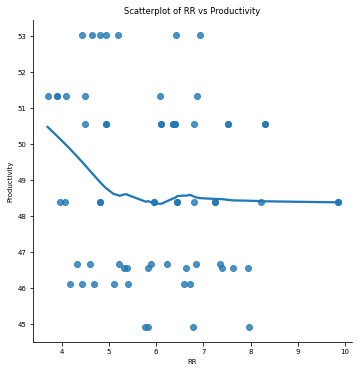

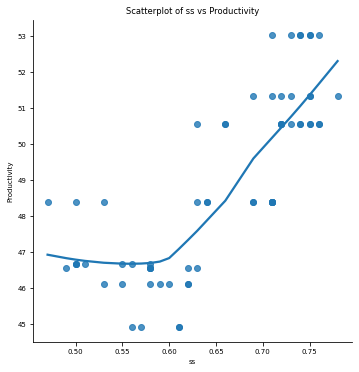

In [271]:
for feature in ['RR', 'ss']:
    sns.lmplot(x=feature, y='Productivity', data=combined_df, lowess=True)
    plt.title(f"Scatterplot of {feature} vs Productivity")
    plt.show()

In [272]:
combined_df['ss^2'] = combined_df['ss'] ** 2

#retrain model with ss^2
df_feature, df_target = get_features_targets(combined_df, ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss^2', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model_aceh_paddy, J_storage = build_model_linreg(df_feature_train, df_target_train)
model_aceh_paddy
beta = model_aceh_paddy['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.7963314504751927
0.829574074651392


Drop low correlation variables seen from visual analysis part.
We will also conduct trial and error to see which feature to remove based on the final adjusted R^2 value

In [273]:
#retrain model with ss^2 
df_feature, df_target = get_features_targets(combined_df, ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss^2', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
print(model)
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2_aceh = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2_aceh)

mse_aceh: float = mean_squared_error(target, pred)
print(mse_aceh)

{'beta': array([[48.83381594],
       [ 0.43317221],
       [-0.67874258],
       [-0.44482581],
       [-0.20104009],
       [ 1.0433025 ],
       [-0.22384992],
       [-0.07104788]]), 'means': array([26.34851064,  8.81148936, 84.25765957,  6.02957447,  0.43805319,
        4.32978723,  1.84042553]), 'stds': array([0.6368706 , 0.38271137, 1.72329004, 1.30371639, 0.11198916,
       0.46029357, 0.26107761])}
0.7963314504751927
0.829574074651392


### 3rd model to predict paddy productivity in Banten province

In [274]:
df_feature, df_target = get_features_targets(province_dfs['banten'], ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.6816471020516313
1.2140997535060858


Optimise for lagged variables

In [275]:
combined_df = get_oct_apr_df('banten')

# retrain model
df_feature, df_target = get_features_targets(combined_df, ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.45704937104505994
2.306834908767832


Since the adjusted R-squared value dropped signigicantly, we will not be applying lagged variables to optimise for the Banten province. This suggest that this province does not follow the 3 paddy cultivation cycle that we have been applying to the other 2 provinces.

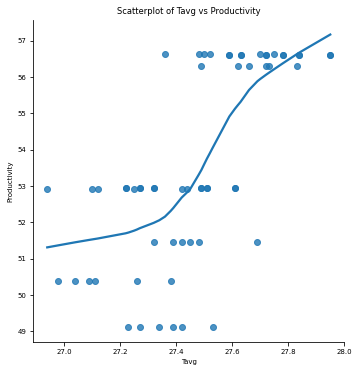

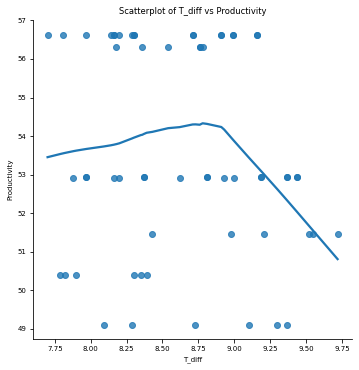

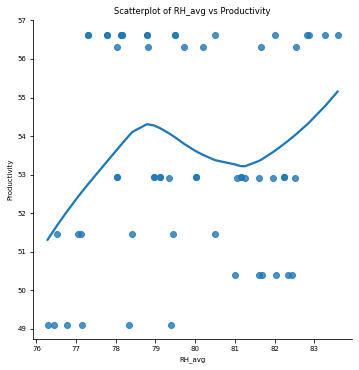

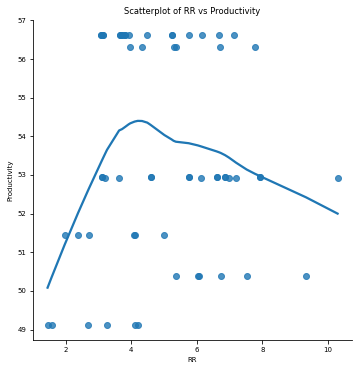

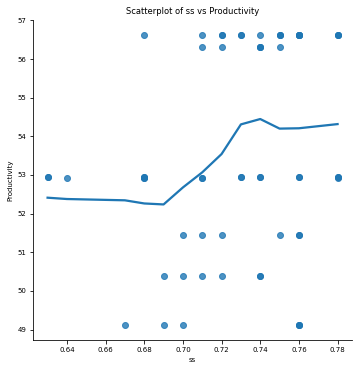

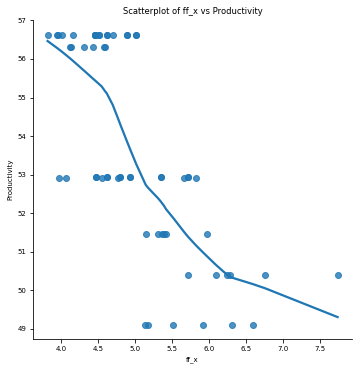

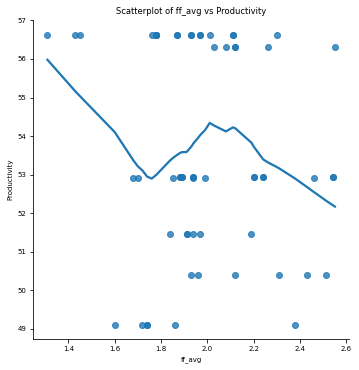

In [276]:
for feature in ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']:
    sns.lmplot(x=feature, y='Productivity', data=province_dfs['banten'], lowess=True)
    plt.title(f"Scatterplot of {feature} vs Productivity")
    plt.show()

In [277]:
province_dfs['banten'] = province_dfs['banten'].copy() 
province_dfs['banten']['ss^2'] = province_dfs['banten']['ss'] ** 2
province_dfs['banten']['Tavg^2'] = province_dfs['banten']['Tavg'] ** 2
province_dfs['banten']['RH_avg^2'] = province_dfs['banten']['RH_avg'] ** 2
province_dfs['banten']['T_diff^2'] = province_dfs['banten']['T_diff'] ** 2
province_dfs['banten']['ff_x^2'] = province_dfs['banten']['ff_x'] ** 2
province_dfs['banten']['ff_avg^2'] = province_dfs['banten']['ff_avg'] ** 2
province_dfs['banten']['RR^2'] = province_dfs['banten']['RR'] ** 2

#retrain model 
df_feature, df_target = get_features_targets(province_dfs['banten'], ['RH_avg^2', 'Tavg^2','T_diff^2','ff_x', 'ff_avg^2', 'RR^2','ss^2'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model_aceh_paddy, J_storage = build_model_linreg(df_feature_train, df_target_train)
model_aceh_paddy
beta = model_aceh_paddy['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.679272349474736
1.2231563273171837


Trial and error iterations to remove weak predictors

In [278]:
df_feature, df_target = get_features_targets(province_dfs['banten'], ['RH_avg^2', 'Tavg^2','ff_x'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
print(model)
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2_banten = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2_banten)

mse_banten: float = mean_squared_error(target, pred)
print(mse_banten)

{'beta': array([[53.70879429],
       [ 1.17925373],
       [ 1.86438646],
       [-0.824817  ]]), 'means': array([6.32804202e+03, 7.55721112e+02, 5.10023810e+00]), 'stds': array([298.96481109,  13.47354114,   0.7942996 ])}
0.866807752806536
0.7111358047628819


### 4th model to predict paddy productivity in Papua province

In [279]:
df_feature, df_target = get_features_targets(province_dfs['papua'], ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.21320572466840415
6.242413210056732


In [280]:
combined_df = get_oct_apr_df('papua')

# retrain model
df_feature, df_target = get_features_targets(combined_df, ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.7637028806622594
2.0682605306976627


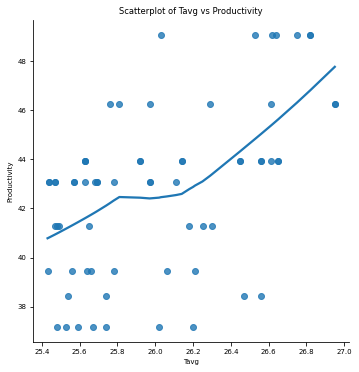

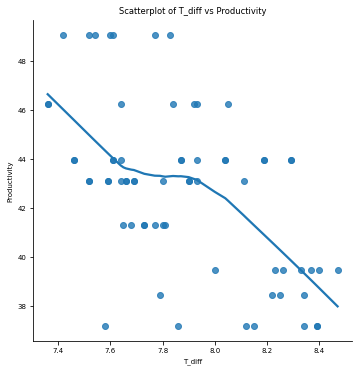

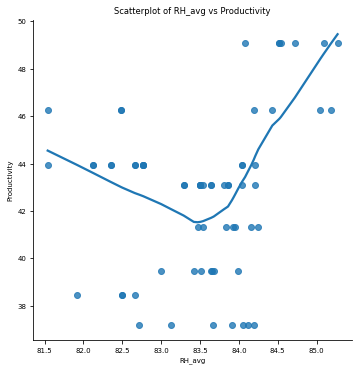

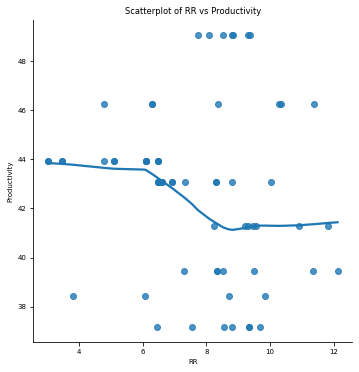

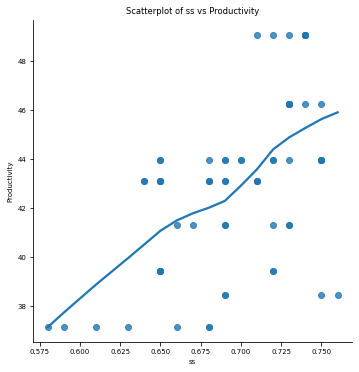

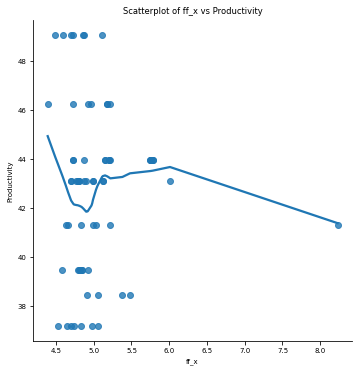

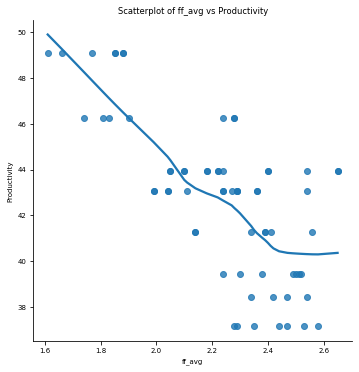

In [281]:
for feature in ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']:
    sns.lmplot(x=feature, y='Productivity', data=combined_df, lowess=True)
    plt.title(f"Scatterplot of {feature} vs Productivity")
    plt.show()

In [282]:
combined_df['T_avg^3'] = combined_df['Tavg'] ** 3
combined_df['RH_avg^2'] = combined_df['RH_avg'] ** 2
combined_df['T_diff^2'] = combined_df['T_diff'] ** 2
combined_df['ff_avg^2'] = combined_df['ff_avg'] ** 2
combined_df['log_ff_x'] = np.log1p(combined_df['ff_x'])
combined_df['RR^2'] = combined_df['RR'] ** 2

#retrain model 
df_feature, df_target = get_features_targets(combined_df, ['RH_avg^2', 'T_avg^3','T_diff^2','ff_x', 'ff_avg^2', 'RR^2','ss'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model_aceh_paddy, J_storage = build_model_linreg(df_feature_train, df_target_train)
model_aceh_paddy
beta = model_aceh_paddy['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.7590972918935232
2.1085723106198997


In [283]:
df_feature, df_target = get_features_targets(combined_df, ['RH_avg^2', 'T_avg^3','T_diff^2','ff_x', 'RR^2','ss'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
print(model)
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2_papua = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2_papua)

mse_papua: float = mean_squared_error(target, pred)
print(mse_papua)

{'beta': array([[ 4.28097751e+01],
       [ 1.71175363e+00],
       [ 1.15552911e+00],
       [-7.96980799e-01],
       [-8.35098209e-03],
       [-1.09179264e+00],
       [ 9.48821767e-01]]), 'means': array([6.97330303e+03, 1.76638155e+04, 6.20605170e+01, 5.06510638e+00,
       6.17559745e+01, 6.97872340e-01]), 'stds': array([1.46073462e+02, 9.40040112e+02, 4.57842067e+00, 5.86971573e-01,
       3.18676811e+01, 3.92447948e-02])}
0.8263356537961022
1.6467193506367586


### 5th model to predict paddy productivity in North Sumatra province

In [284]:
df_feature, df_target = get_features_targets(province_dfs['north sumatra'], ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.6673842026965918
0.5471622258918091


In [285]:
combined_df = get_oct_apr_df('north sumatra')

# retrain model
df_feature, df_target = get_features_targets(combined_df, ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
model
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.6378920274967268
0.5914487138385628


A slight drop in adjusted R-squared value here is not enough to suggest that the province doesn't follow the 3 paddy cultivation cycle.
We think it is better to account for the cycle here since this is a widely used cultivation practive for paddy crop across Indonesia.

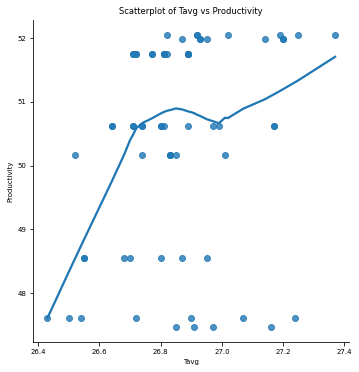

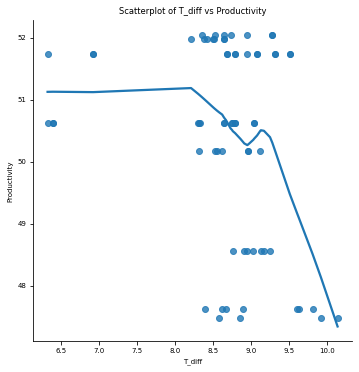

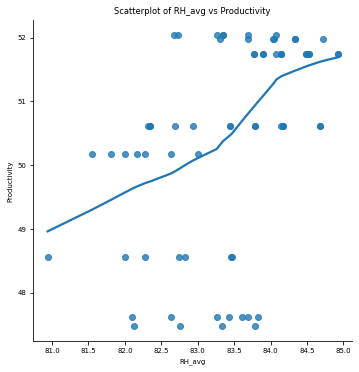

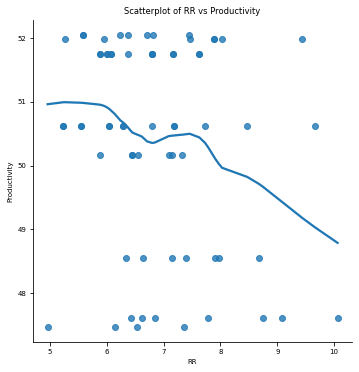

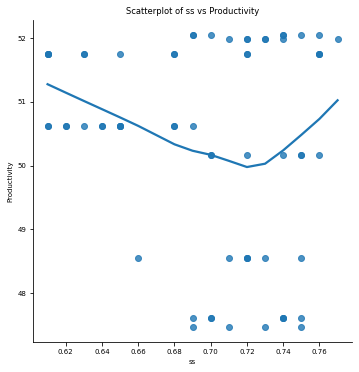

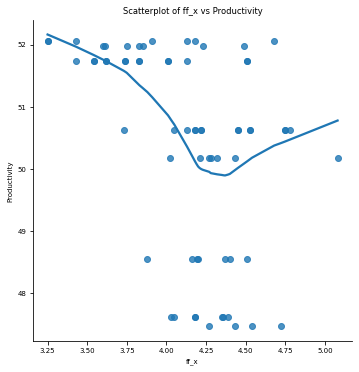

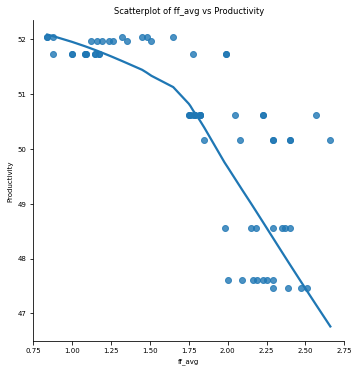

In [286]:
for feature in ['Tavg', 'T_diff', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg']:
    sns.lmplot(x=feature, y='Productivity', data=combined_df, lowess=True)
    plt.title(f"Scatterplot of {feature} vs Productivity")
    plt.show()

In [287]:
combined_df['T_avg^3'] = combined_df['Tavg'] ** 3
combined_df['RH_avg^2'] = combined_df['RH_avg'] ** 2
combined_df['T_diff^2'] = combined_df['T_diff'] ** 2
combined_df['ff_x^2'] = combined_df['ff_x'] ** 2
combined_df['log_ff_avg'] = np.log1p(combined_df['ff_avg'])
combined_df['RR^2'] = combined_df['RR'] ** 2
combined_df['ss^2'] = combined_df['ss'] ** 2


#retrain model 
df_feature, df_target = get_features_targets(combined_df, ['RH_avg^2', 'T_avg^3','T_diff^2','log_ff_avg', 'ff_x^2', 'RR^2','ss^2'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model_aceh_paddy, J_storage = build_model_linreg(df_feature_train, df_target_train)
model_aceh_paddy
beta = model_aceh_paddy['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2 = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2)

mse: float = mean_squared_error(target, pred)
print(mse)

0.6486908736811718
0.5738104286536854


In [288]:
df_feature, df_target = get_features_targets(combined_df, ['RH_avg^2', 'T_diff^2','log_ff_avg', 'ff_x'], ["Productivity"])
df_feature_train, df_feature_test, df_target_train, df_target_test = split_data(df_feature, df_target, random_state=100, test_size=0.3)
model, J_storage = build_model_linreg(df_feature_train, df_target_train)
print(model)
beta = model['beta']
pred: np.ndarray = predict_linreg(df_feature_test.to_numpy(), beta)
target: np.ndarray = df_target_test.to_numpy()
p = df_feature_test.shape[1]
n = target.shape[0]
adjusted_r2_north_sumatra = adjusted_r2_score(target, pred, n, p)
print(adjusted_r2_north_sumatra)

mse_north_sumatra: float = mean_squared_error(target, pred)
print(mse_north_sumatra)

{'beta': array([[50.41317719],
       [-0.29787804],
       [-0.40738854],
       [-2.17288809],
       [ 0.86305025]]), 'means': array([6.95890168e+03, 7.60565383e+01, 9.85647059e-01, 4.12000000e+00]), 'stds': array([150.80859197,  10.87719855,   0.20122558,   0.403585  ])}
0.7255120391204244
0.5604183135767855


In [289]:
print("Aceh paddy productivity model's adjusted R2 and MSE:", round(adjusted_r2_aceh, 2),',',round(mse_aceh, 2))
print("Central Kalimantan paddy productivity model's adjusted R2 and MSE:", round(adjusted_r2_central_kalimantan, 2),',',round(mse_central_kalimantan, 2))
print("North Sumatra paddy productivity model's adjusted R2 and MSE:", round(adjusted_r2_north_sumatra, 2),',',round(mse_north_sumatra, 2))
print("Papua paddy productivity model's adjusted R2 and MSE:", round(adjusted_r2_papua, 2),',',round(mse_papua, 2))
print("Banten paddy productivity model's adjusted R2 and MSE:", round(adjusted_r2_banten, 2),',',round(mse_banten, 2))



Aceh paddy productivity model's adjusted R2 and MSE: 0.8 , 0.83
Central Kalimantan paddy productivity model's adjusted R2 and MSE: 0.55 , 2.59
North Sumatra paddy productivity model's adjusted R2 and MSE: 0.73 , 0.56
Papua paddy productivity model's adjusted R2 and MSE: 0.83 , 1.65
Banten paddy productivity model's adjusted R2 and MSE: 0.87 , 0.71


# Discussion and Analysis

### Analyze the results of our model metrics:
Out of the 5 models that we built, Banten achieves the best performance overall, with the highest adjused R2 and a low MSE. This indicates that the model parameters (climate) are highly effective at capturing the paddy productivity in this province. Interestingly, Banten stands out as the only province among the five studied that does not adhere to the traditional paddy planting cycle. The indigenous Sundanese people of Banten follow traditional ecological calendars and rituals, which dictate planting and harvesting times. These practices deviate from the conventional monsoon-aligned cycles observed in other provinces, possibly leading to more predictable and stable productivity patterns. Such alignment between agricultural activities and local environmental conditions enhances the model's accuracy in this province.

In contrast, the performance in Central Kalimantan is relatively poor, with only 55% of the variance explained. The high MSE suggests the predictions are less accurate. This indicate that weather variables are not an effective predictor for paddy productivity in the province.
Research shows that Central Kalimantan province experiences recurring forest and land fires, especially during the dry season. These fires disrupt agricultural activities and damage paddy fields which might give an explaination on the poor model performance.

### How does our analysis and machine learning help to solve our problem statement:
Our project creates localise models for provinces and for specific crop like paddy (rice). This was done by analysing the crop cultivation cycle, the province's algriculture practices and apply a linear regression model. 

Our model leverages a machine learning model trained on seven years of weather and agricultural data to provide early predictions of crop yields for provinces across Indonesia. This system addresses the problem of slow importation and enhances food security in several ways:

1. Early Importation Decisions: By predicting low-yield scenarios early, the government can initiate the rice importation process well in advance, avoiding delays caused by the lengthy approval process.

2. Efficient Resource Allocation: The model enables targeted resource distribution, including subsidies and food aid, to areas at risk of shortages.

3. Proactive Planning: It allows policymakers to plan for alternative food sources and adjust subsidies or incentives to stabilize food supplies and markets.

4. Market Stabilization: With better forecasting, surplus regions can redistribute excess produce to shortage-prone areas, minimizing waste and maintaining market balance.

This system provides the tools necessary to move from reactive to proactive food security management, addressing inefficiencies in the current import-dependent framework and safeguarding against potential crises​

### Conclusion
The results of our analysis highlight the value of localised, data-driven approaches to understanding and addressing food security challenges. By tailoring models to specific provinces and incorporating unique agricultural practices, such as those of the Sundanese people in Banten, we achieved higher accuracy and predictive power in province where local environmental and cultural factors align closely with climate data. This underscores the importance of integrating contextual knowledge into model development to enhance its utility and relevance.

However, the poorer performance of the model in regions like Central Kalimantan demonstrates that weather variables alone is not enough to capture the complexities of agricultural productivity. Factors such as environmental disruptions (e.g., forest fires) or socio-economic variables could play a significant role, suggesting a need for incorporating additional datasets or qualitative variables in future iterations. Expanding our model to account for these variables could help bridge the gap and improve prediction accuracy across diverse regions.

Ultimately, our machine learning approach represents a crucial step toward proactive food security management in Indonesia. By providing early, localized yield predictions, this system empowers policymakers to make timely and informed decisions, thereby reducing dependency on imports, enhancing resource allocation, and stabilizing markets. These improvements can significantly strengthen Indonesia's resilience to agricultural disruptions, ensuring better outcomes for farmers, consumers, and the overall food system.

# Suggestion for future studies
- Improving Missing Data Assumptions: One of the assumptions for the missing rainfall values in our weather data is that there was no rain. However, this is a weak assumption and could be improved by conducting more detailed research on the specific weather patterns (wet season and dry season) and historical rainfall patterns of each province.

- Incorporating Non-Weather Variables: Our current model focuses primarily on weather data to predict crop yield. Future studies could explore the inclusion of non-weather factors, such as soil quality, pest outbreaks, socio-economic conditions (market price), and irrigation infrastructure. These variables could improve model performance, particularly in provinces like Central Kalimantan, where weather alone does not adequately explain productivity variations.

- Accounting for Environmental Disruptions: In provinces prone to environmental disruptions like forest fires or floods, future research could incorporate event-based models to capture their impact on agricultural yields. Machine learning techniques like anomaly detection could be used to identify and adjust for these events in the data.

- Cross-Regional Analysis: Expanding the study to include other Southeast Asian countries with similar agricultural challenges could provide valuable comparative insights. This would also help generalize the model for broader applications and enhance regional collaboration on food security.
